# Capstone Project 3: 
## Part II: Data Processing and EDA

In Part II of the project we will work with the cleaned data saved at the end of Part I.

The goal here is to process and explore the data from key independent features and to create a target variable which we can use in a classification model to make predictions accordingly.

In [1]:
# Import relevant libraries and packages

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style = 'whitegrid', font_scale = 1.8)

In [2]:
# Ignore warnings

import warnings
warnings.filterwarnings('ignore')

In [3]:
# load clean data

file_read = 'data/jobs_ds_s1_s5_'

data = pd.read_excel(file_read + 'clean.xlsx')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10165 entries, 0 to 10164
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Job Title                 10165 non-null  object
 1   Company Name              10165 non-null  object
 2   Industry                  10165 non-null  object
 3   Job Function              10165 non-null  object
 4   Metro Area                10165 non-null  object
 5   Education-Bachelor        10165 non-null  int64 
 6   Education-Master          10165 non-null  int64 
 7   Education-Doctor          10165 non-null  int64 
 8   Minimum Experience        10165 non-null  int64 
 9   Seniority Level           10165 non-null  object
 10  Data Science Terms Count  10165 non-null  int64 
 11  Time Posted               10165 non-null  int64 
 12  Number of Applicants      10165 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 1.0+ MB


In [4]:
# display first few records

data.head()

,Job Title,Company Name,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Minimum Experience,Seniority Level,Data Science Terms Count,Time Posted,Number of Applicants
0,Data Scientist,Honeywell,Staffing and Recruiting,Engineering,ATL,0,1,1,2,entry,7,2,40
1,Data Scientist,SynergisticIT,Staffing and Recruiting,Information Technology,ATL,1,1,0,10,entry,2,1,0
2,Data Scientist,Inspire Brands,Financial Services,Engineering,ATL,0,0,0,1,entry,4,1,25
3,Data Scientist,The Home Depot,Financial Services,Engineering,ATL,0,1,0,2,entry,3,1,29
4,Data Scientist,Edelman Data & Intelligence (DxI),Research,Analyst,ATL,0,0,0,0,entry,3,1,0


- **Time Posted** and **Number of Applicants**

As a job seeker, **'Time Posted'** and **'Number of Applicants'** are perhaps the most critical features. In part I, when the relevant information for the number of applicants was extracted, we set the number to 0 for postings with text "Be among the first 25 applicants". Here, we will assign more appropriate values for these records. However, as a better metric we will create a new feature 'Applicants per Day'.

Before proceeding with that, we would like to examine if 'Time Posted' has 0 values.

In [5]:
# check the number of records with 'Time Posted' values of 0
print(len(data[data['Time Posted'] == 0]))

57


In [6]:
# display these records
data[data['Time Posted'] == 0]

,Job Title,Company Name,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Minimum Experience,Seniority Level,Data Science Terms Count,Time Posted,Number of Applicants
95,Manager,Rapid7,Internet,Marketing,BOS,1,0,0,5,entry,1,0,0
188,Data Scientist,Edelman Data & Intelligence (DxI),Research,Analyst,DC,0,0,0,0,entry,3,0,0
320,Data Scientist,Foot Locker,Retail,Engineering,NY,0,1,1,4,entry,17,0,0
321,Data Engineer,United Talent Agency,Marketing and Advertising,Information Technology,NY,0,0,0,5,entry,1,0,0
322,Data Scientist,Goldman Sachs,Financial Services,Engineering,NY,1,0,0,0,entry,8,0,0
483,Data Scientist,Walmart,Internet,Engineering,SF,1,1,1,2,entry,16,0,0
577,Data Scientist,Pfizer,Pharmaceutical,Manufacturing,BOS,1,1,0,5,associate,4,0,0
1080,Data Engineer,"ActiveCove, Inc",Information Technology and Services,Engineering,SF,1,0,0,6,associate,4,0,0
1195,Data Engineer,GreatCall,Medical Devices,Analyst,BOS,1,1,0,3,senior,1,0,46
1293,Machine Learning Engineer,Lawrence Harvey,Staffing and Recruiting,Research,DC,0,1,1,2,senior,12,0,161


There are only 57 records (out of 10165 entries) with 'Time Posted' values of 0. Most of them have 0 number of applicants. The few exceptions have a large number of applicants which makes them outliers. In addition, these records represent approximately 0.005% of all data. 

Therefore, it is justified to remove these records without concerns for biasing our data analysis and modeling.

In [7]:
# eliminate the records with 'Time Posted' = 0 and create new data set data_1
data_1 = data[data['Time Posted'] != 0]
data_1.reset_index(inplace = True, drop = True)
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10108 entries, 0 to 10107
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Job Title                 10108 non-null  object
 1   Company Name              10108 non-null  object
 2   Industry                  10108 non-null  object
 3   Job Function              10108 non-null  object
 4   Metro Area                10108 non-null  object
 5   Education-Bachelor        10108 non-null  int64 
 6   Education-Master          10108 non-null  int64 
 7   Education-Doctor          10108 non-null  int64 
 8   Minimum Experience        10108 non-null  int64 
 9   Seniority Level           10108 non-null  object
 10  Data Science Terms Count  10108 non-null  int64 
 11  Time Posted               10108 non-null  int64 
 12  Number of Applicants      10108 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 1.0+ MB


Since we have eliminated the zero values in 'Time Posted', we can now create the new feature 'Applicants per Day'.

In [8]:
# create new feature 'Applicants per Day'
data_1['Applicants per Day'] = (data_1['Number of Applicants'] / data_1['Time Posted']).astype(int)
data_1.head(10)

,Job Title,Company Name,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Minimum Experience,Seniority Level,Data Science Terms Count,Time Posted,Number of Applicants,Applicants per Day
0,Data Scientist,Honeywell,Staffing and Recruiting,Engineering,ATL,0,1,1,2,entry,7,2,40,20
1,Data Scientist,SynergisticIT,Staffing and Recruiting,Information Technology,ATL,1,1,0,10,entry,2,1,0,0
2,Data Scientist,Inspire Brands,Financial Services,Engineering,ATL,0,0,0,1,entry,4,1,25,25
3,Data Scientist,The Home Depot,Financial Services,Engineering,ATL,0,1,0,2,entry,3,1,29,29
4,Data Scientist,Edelman Data & Intelligence (DxI),Research,Analyst,ATL,0,0,0,0,entry,3,1,0,0
5,Data Scientist,Leidos,Defense,Engineering,ATL,1,0,0,1,entry,10,1,0,0
6,Data Scientist,Georgia-Pacific LLC,Construction,Engineering,ATL,0,1,0,2,entry,7,2,27,13
7,Data Scientist,Vanderlande,Staffing and Recruiting,Information Technology,ATL,1,0,0,4,entry,4,1,0,0
8,Data Scientist,Search Discovery,Marketing and Advertising,Engineering,ATL,0,0,0,2,entry,7,1,0,0
9,Data Scientist,Mailchimp,Internet,Engineering,ATL,0,0,0,2,entry,6,5,192,38


We are considering to fill the 'Applicants per Day' 0 values with the average values for specific **Job Title**, **Metro Area** and **Seniority Level**. However, such fine segmentation of the data poses the risk of not having available data from which to obtain some of the corresponding average values. Therefore, we would like to examine what the relative percentage of zero values is for the different seniority levels and some of the most common job titles.

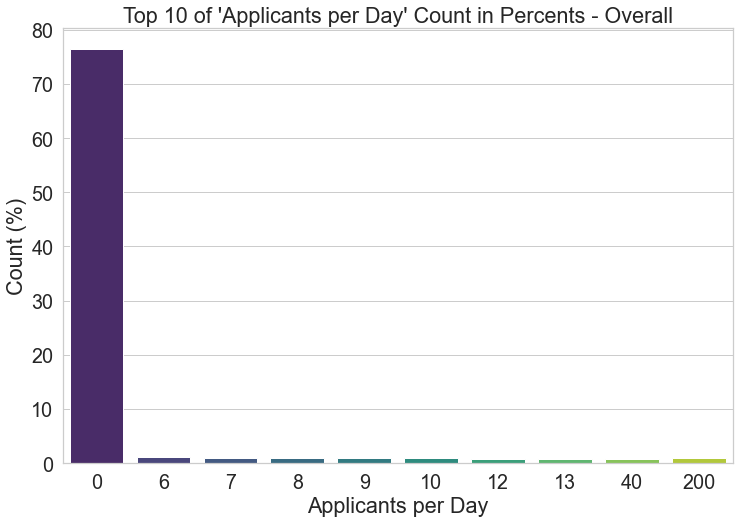

In [9]:
# get the overall count of 'Applicants per Day' and plot the top 10
n_pts = 10

count_appl = data_1['Applicants per Day'].value_counts(normalize = True) * 100

plt.figure(figsize = (12, 8))
sns.barplot(x = count_appl.iloc[0:10].index, y = count_appl.iloc[0:10].values, palette = 'viridis')
plt.xlabel('Applicants per Day')
plt.ylabel('Count (%)')
plt.title("Top 10 of 'Applicants per Day' Count in Percents - Overall")

plt.show()

In [10]:
# define a function to produce the same results for different fieatures
data_feature = 'Seniority Level'
feat_value = 'entry'
count_feature = 'Applicants per Day'
n_pts = 10

def feature_count_plot(data, data_feature, feat_value, count_feature, n_pts):
    feat_count = data[data[data_feature] == feat_value][count_feature].value_counts(normalize = True) * 100
    
    plt.figure(figsize = (12, 8))
    sns.barplot(x = feat_count.iloc[0:n_pts].index, y = feat_count.iloc[0:n_pts].values, palette = 'viridis')
    plt.xlabel(count_feature)
    plt.ylabel('Count (%)')
    plt.title('Top ' + str(n_pts) + " of '" + count_feature + "' Count in Percents: " + data_feature + ' - ' + feat_value)

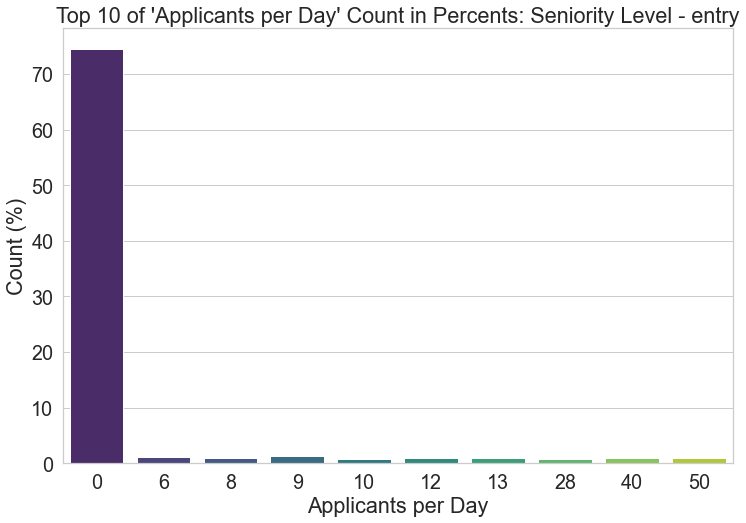

In [11]:
# count plot of 'Applicants per Day' for entry level
feat_value = 'entry'
n_pts = 10

feature_count_plot(data_1, data_feature, feat_value, count_feature, n_pts)

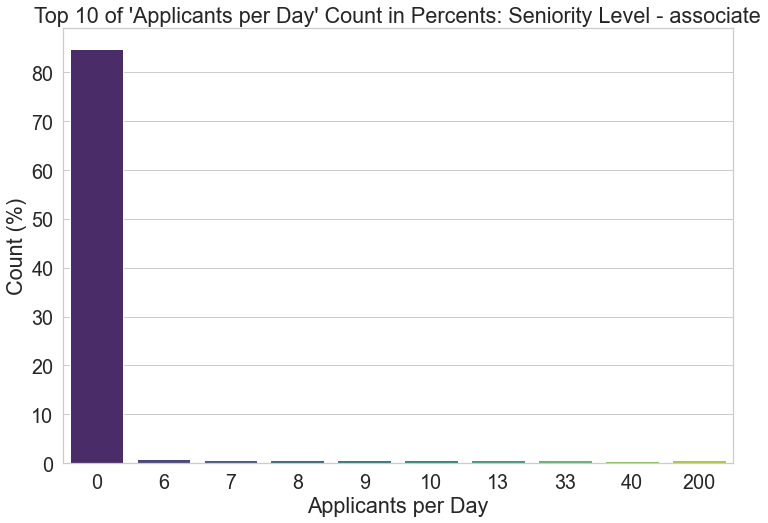

In [12]:
# count plot of 'Applicants per Day' for associate level
feat_value = 'associate'
n_pts = 10

feature_count_plot(data_1, data_feature, feat_value, count_feature, n_pts)

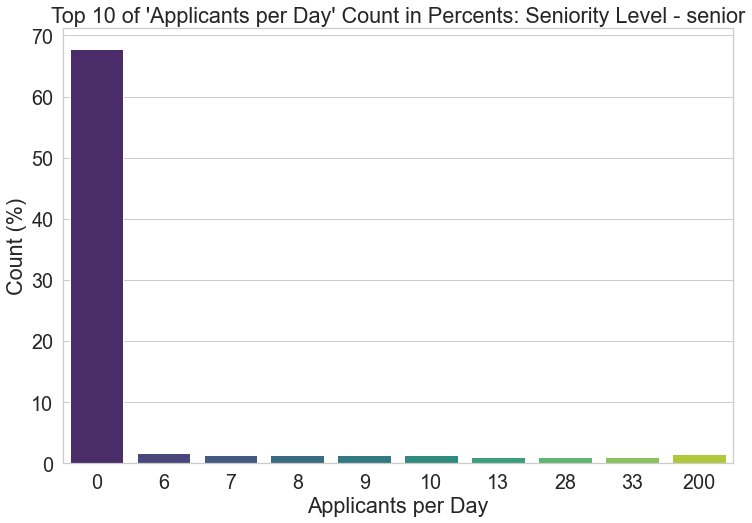

In [13]:
# count plot of 'Applicants per Day' for senior level
feat_value = 'senior'
n_pts = 10

feature_count_plot(data_1, data_feature, feat_value, count_feature, n_pts)

All seniority levels have similarly large percent of zero values for 'Applicants per Day'.

Let's examine the case for several common job titles.

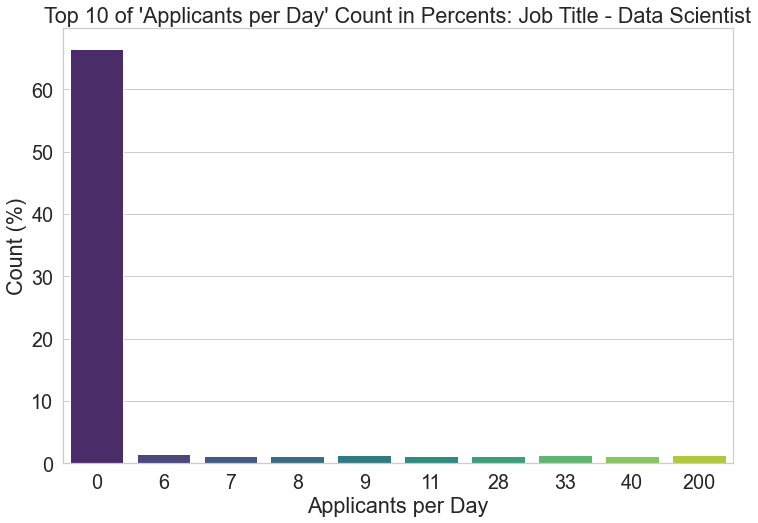

In [14]:
# plot of 'Applicants per Day' count for 'Data Scientist'

data_feature = 'Job Title'
feat_value = 'Data Scientist'
count_feature = 'Applicants per Day'
n_pts = 10

feature_count_plot(data_1, data_feature, feat_value, count_feature, n_pts)

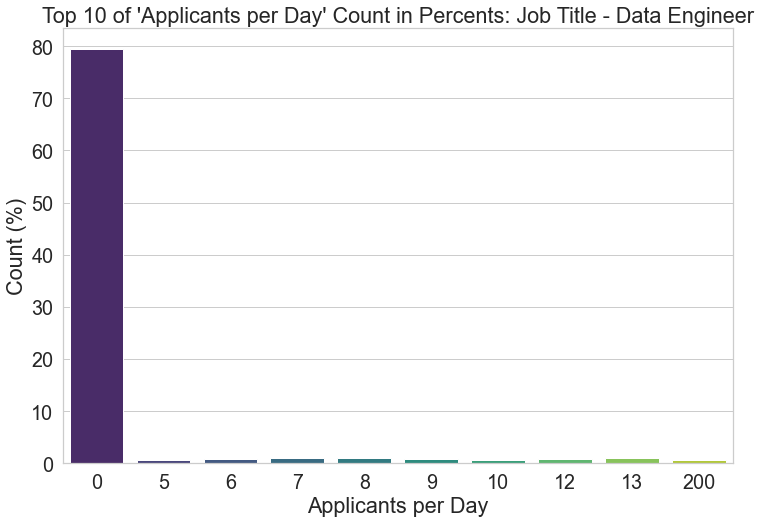

In [15]:
# plot of 'Applicants per Day' count for 'Data Engineer'

feat_value = 'Data Engineer'
n_pts = 10

feature_count_plot(data_1, data_feature, feat_value, count_feature, n_pts)

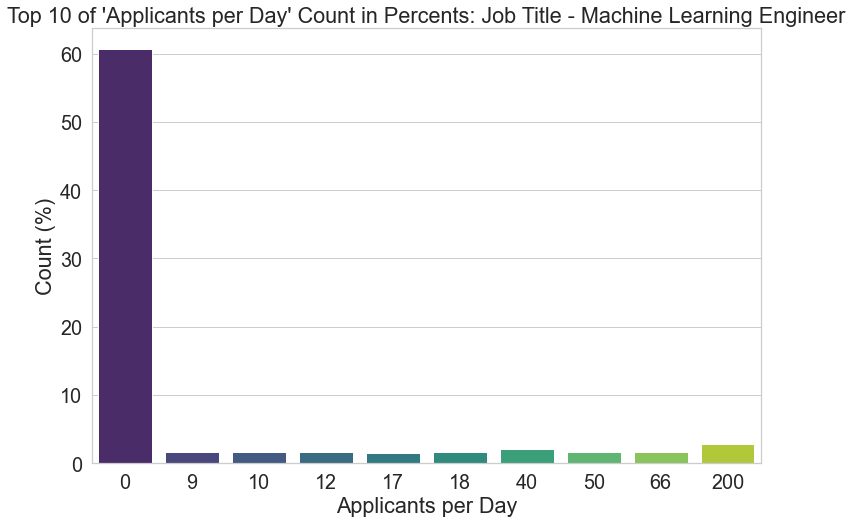

In [16]:
# plot of 'Applicants per Day' count for 'Machine Learning Engineer'

feat_value = 'Machine Learning Engineer'
n_pts = 10

feature_count_plot(data_1, data_feature, feat_value, count_feature, n_pts)

The situation with job titles is similar to the position seniority level. 

This is not a perfect situation, but we will try to get the best from our data. Since it is reasonable to expect that the metro area makes the most significant difference in the number of applicants, we will impute the 0 values using the average values of 'Applicants per Day' for different metro areas.

In [17]:
# create list for 'Metro Area'

list_metro = data_1['Metro Area'].value_counts().index
list_metro

Index(['NY', 'DC', 'SF', 'BOS', 'CHI', 'LA', 'SEA', 'ATL', 'DAL', 'PHI', 'AUS',
       'SD', 'HOU', 'PHX', 'POR', 'NC'],
      dtype='object')

In [18]:
# fill the 0 values of 'Applicants per Day' accordingly
# if mean is greater than 25 set value = 25!

for item in list_metro:
    # filter by rows with 'Applicants per Day' = 0 and 'Time Posted' = 1
    mask_0a = (data_1['Metro Area'] == item) & (data_1['Applicants per Day'] == 0) & (data_1['Time Posted'] == 1)
        
    # filter by rows with 'Applicants per Day' = 0 and 'Time Posted' > 1
    mask_0b = (data_1['Metro Area'] == item) & (data_1['Applicants per Day'] == 0) & (data_1['Time Posted'] > 1)
            
    # rows with 'Applicants per Day' != 0
    mask_1 = (data_1['Metro Area'] == item) & (data_1['Applicants per Day'] != 0)
            
    mean_1 = data_1['Applicants per Day'][mask_1]
            
    if mean_1.size == 0: # accounts for the possibility that all of the 'Applicants per Day' values are 0
        data_1['Applicants per Day'][mask_0a] = 25
        data_1['Applicants per Day'][mask_0b] = 25 / data_1['Time Posted'][mask_0b]
    else:
        mean_1 = int(round(mean_1.mean(), 0))
        
        if mean_1 < 25:
            data_1['Applicants per Day'][mask_0a] = mean_1
            data_1['Applicants per Day'][mask_0b] = 25 / data_1['Time Posted'][mask_0b]
        else:
            data_1['Applicants per Day'][mask_0a] = 25
            data_1['Applicants per Day'][mask_0b] = 25 / data_1['Time Posted'][mask_0b]

In [19]:
# convert Applicants per Day values into integers
data_1['Applicants per Day'] = data_1['Applicants per Day'].astype(int)

data_1.head(10)

,Job Title,Company Name,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Minimum Experience,Seniority Level,Data Science Terms Count,Time Posted,Number of Applicants,Applicants per Day
0,Data Scientist,Honeywell,Staffing and Recruiting,Engineering,ATL,0,1,1,2,entry,7,2,40,20
1,Data Scientist,SynergisticIT,Staffing and Recruiting,Information Technology,ATL,1,1,0,10,entry,2,1,0,25
2,Data Scientist,Inspire Brands,Financial Services,Engineering,ATL,0,0,0,1,entry,4,1,25,25
3,Data Scientist,The Home Depot,Financial Services,Engineering,ATL,0,1,0,2,entry,3,1,29,29
4,Data Scientist,Edelman Data & Intelligence (DxI),Research,Analyst,ATL,0,0,0,0,entry,3,1,0,25
5,Data Scientist,Leidos,Defense,Engineering,ATL,1,0,0,1,entry,10,1,0,25
6,Data Scientist,Georgia-Pacific LLC,Construction,Engineering,ATL,0,1,0,2,entry,7,2,27,13
7,Data Scientist,Vanderlande,Staffing and Recruiting,Information Technology,ATL,1,0,0,4,entry,4,1,0,25
8,Data Scientist,Search Discovery,Marketing and Advertising,Engineering,ATL,0,0,0,2,entry,7,1,0,25
9,Data Scientist,Mailchimp,Internet,Engineering,ATL,0,0,0,2,entry,6,5,192,38


We have replaced the 0 values and now we will examine how successful the imputation was.

In [20]:
# check the count after imputing
n_pts = 10

check_count = data_1['Applicants per Day'].value_counts(normalize = True) * 100
print(round(check_count.iloc[0:n_pts], 1))

25    19.1
6     16.6
8     11.8
12    10.2
5     10.0
4      8.1
3      4.5
9      1.0
21     0.9
7      0.9
Name: Applicants per Day, dtype: float64


Although after imputation the count of 25 applicants per day is still relatively high, we have managed to reduce it to approximately 19% compared to the original 77%. Also, we would like to note that some of these records are not due to our imputing, but are true 25 applicants from the original data. So, the percentage of ambiguous 25 applicants per day is even smaller than 19%.

At this point, we would like to examine the distribution of the 'Applicants per Day' values after the imputation. It could give us an idea of the expected number of postings with 25 applicants per day based on the distribution of the rest of the available values.

In [21]:
# define a function to plot the histogram of the values of differrent data features

hist_feature = 'Applicants per Day'

bin_size = 5

# define function
def plot_histogram_overall(data, hist_feature, bin_size):
    feat_values = data[hist_feature]
    n_bins = int((feat_values.max() - feat_values.min()) // bin_size) # make sure to define it as an integer
    
    plt.figure(figsize = (12, 8))
    plt.hist(feat_values, bins = n_bins)
    plt.xlabel(hist_feature)
    plt.ylabel('Number of Postings')
    plt.title(hist_feature + ' Distribution - Overall', pad = 15)
    plt.show()

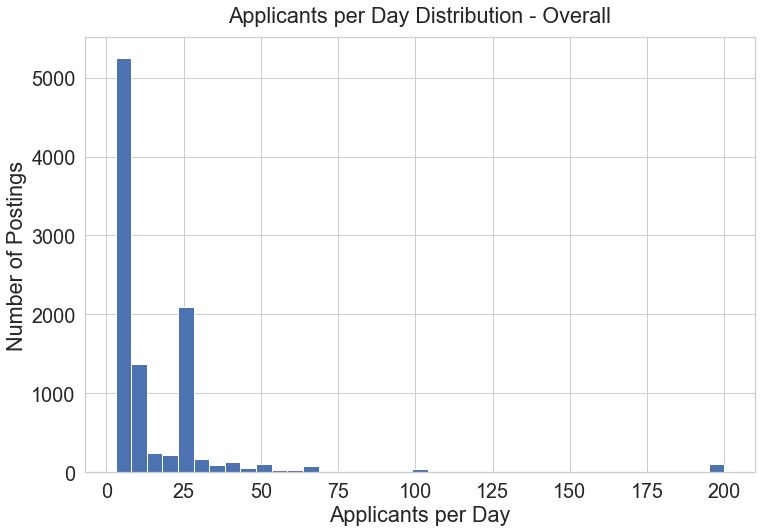

In [22]:
# plot the histogram of 'Applicants per Day'
hist_feature = 'Applicants per Day'

plot_histogram_overall(data_1, hist_feature, 5)

As already indicated, the count of 25 applicants per day is abnormally high. We can estimate the approximate expected number by a simple fit to the observed distribution.

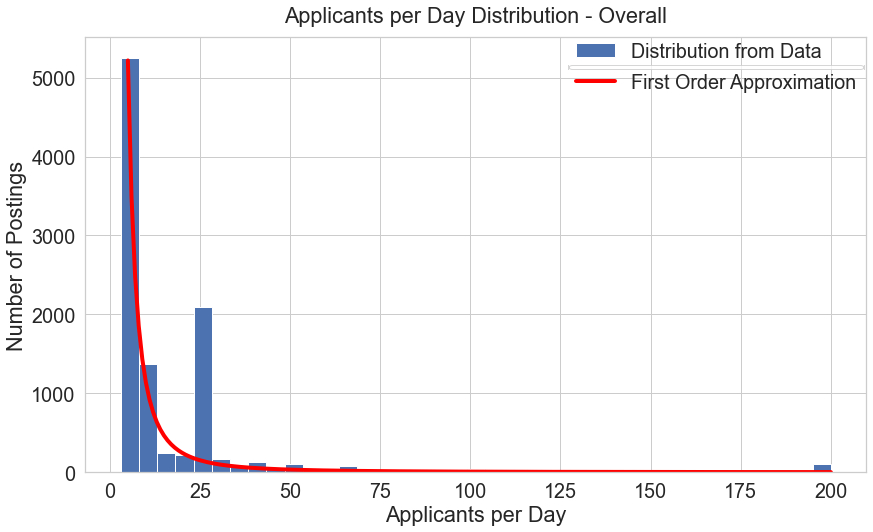

In [23]:
# simple fit to the distribution
a = 18.0
b = 10000.0
c = 2.2
x = np.arange(200) + 1
y = (a * b) / x**c
n_start = 4

feat_values = data_1[hist_feature]
n_bins = int((feat_values.max() - feat_values.min()) // bin_size)

plt.figure(figsize = (14, 8))
plt.hist(feat_values, bins = n_bins, label = 'Distribution from Data')
plt.plot(x[n_start:], y[n_start:], color = 'red', linewidth = 4, label = 'First Order Approximation')
plt.xlabel(hist_feature)
plt.ylabel('Number of Postings')
plt.title(hist_feature + ' Distribution - Overall', pad = 15)
plt.legend(bbox_to_anchor = (1.01, 0.96), labelspacing = -2.5)

plt.show()

The red line appears a good first-order approximation from which we can find the expected number of records with 25 applicants per day.

In [24]:
x = 25
y = (a * b) / x**c
print(round(y, 2))

151.29


According to the fit to the distribution, it appears that we should expect approximately 150 cases with 25 applicants per day. Unfortunately, while this result tells us how many such records there should be, it doesn't tell us in what way to replace the current 25 applicants per day with a more reasonable number. This, however, should not be a problem since we don't need to know exact discrete numbers. Here, we are trying to answer the question which job postings have the highest, lowest and medium number of applicants. So, it is not necessary to know whether that number is 18 or 21. Using quartiles to assign different categories corresponding to the degree of demand for a particular position is the best way to set up and solve our problem.

We will assign different categories of position demand which encompasses a range of values of applicants per day. The break down of different classes is as follows*:

- Class 1: 0-6 applicants per day (n < 7)
- Class 2: 7-12 applicants per day (7 =< n < 13)
- Class 3: 13-25 applicants per day (13 =< n < 26)
- Class 4: 26+ applicants per day (26 =< n)

(*) We would like to note that several different segmentations were tested and this case provided the best model predictions results. In addition, we will compare with a very similar segmentation to demonstrate how small differences in setting the problem can lead to significantly different results.

In [25]:
# create new feature 'Position Demand' and initialize with 0 values

data_1['Position Demand'] = 0

data_1.head(10)

,Job Title,Company Name,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Minimum Experience,Seniority Level,Data Science Terms Count,Time Posted,Number of Applicants,Applicants per Day,Position Demand
0,Data Scientist,Honeywell,Staffing and Recruiting,Engineering,ATL,0,1,1,2,entry,7,2,40,20,0
1,Data Scientist,SynergisticIT,Staffing and Recruiting,Information Technology,ATL,1,1,0,10,entry,2,1,0,25,0
2,Data Scientist,Inspire Brands,Financial Services,Engineering,ATL,0,0,0,1,entry,4,1,25,25,0
3,Data Scientist,The Home Depot,Financial Services,Engineering,ATL,0,1,0,2,entry,3,1,29,29,0
4,Data Scientist,Edelman Data & Intelligence (DxI),Research,Analyst,ATL,0,0,0,0,entry,3,1,0,25,0
5,Data Scientist,Leidos,Defense,Engineering,ATL,1,0,0,1,entry,10,1,0,25,0
6,Data Scientist,Georgia-Pacific LLC,Construction,Engineering,ATL,0,1,0,2,entry,7,2,27,13,0
7,Data Scientist,Vanderlande,Staffing and Recruiting,Information Technology,ATL,1,0,0,4,entry,4,1,0,25,0
8,Data Scientist,Search Discovery,Marketing and Advertising,Engineering,ATL,0,0,0,2,entry,7,1,0,25,0
9,Data Scientist,Mailchimp,Internet,Engineering,ATL,0,0,0,2,entry,6,5,192,38,0


In [26]:
# fill in the appropriate values
n_appl = 0

for i in range(len(data_1)):
    n_appl = data_1['Applicants per Day'][i]
    
    if n_appl < 7:
        data_1['Position Demand'][i] = 1
    elif n_appl >= 7 and n_appl < 13:
        data_1['Position Demand'][i] = 2
    elif n_appl >= 13 and n_appl < 26:
        data_1['Position Demand'][i] = 3
    else:
        data_1['Position Demand'][i] = 4

In [27]:
# check
data_1.head(10)

,Job Title,Company Name,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Minimum Experience,Seniority Level,Data Science Terms Count,Time Posted,Number of Applicants,Applicants per Day,Position Demand
0,Data Scientist,Honeywell,Staffing and Recruiting,Engineering,ATL,0,1,1,2,entry,7,2,40,20,3
1,Data Scientist,SynergisticIT,Staffing and Recruiting,Information Technology,ATL,1,1,0,10,entry,2,1,0,25,3
2,Data Scientist,Inspire Brands,Financial Services,Engineering,ATL,0,0,0,1,entry,4,1,25,25,3
3,Data Scientist,The Home Depot,Financial Services,Engineering,ATL,0,1,0,2,entry,3,1,29,29,4
4,Data Scientist,Edelman Data & Intelligence (DxI),Research,Analyst,ATL,0,0,0,0,entry,3,1,0,25,3
5,Data Scientist,Leidos,Defense,Engineering,ATL,1,0,0,1,entry,10,1,0,25,3
6,Data Scientist,Georgia-Pacific LLC,Construction,Engineering,ATL,0,1,0,2,entry,7,2,27,13,3
7,Data Scientist,Vanderlande,Staffing and Recruiting,Information Technology,ATL,1,0,0,4,entry,4,1,0,25,3
8,Data Scientist,Search Discovery,Marketing and Advertising,Engineering,ATL,0,0,0,2,entry,7,1,0,25,3
9,Data Scientist,Mailchimp,Internet,Engineering,ATL,0,0,0,2,entry,6,5,192,38,4


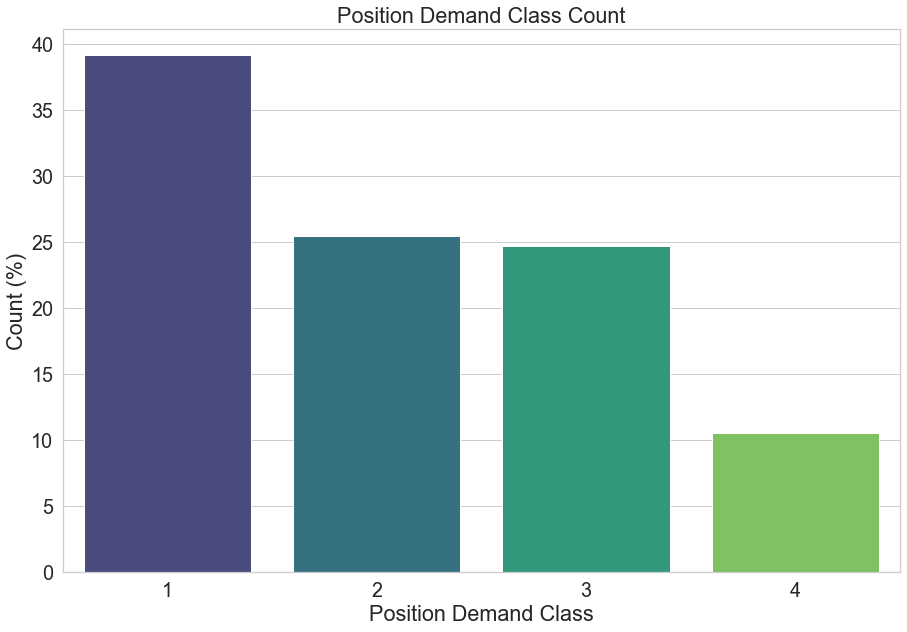

In [28]:
# get and plot the demand value count

count_demand = data_1['Position Demand'].value_counts(normalize = True) * 100

plt.figure(figsize = (15, 10))
sns.barplot(x = count_demand.index, y = count_demand.values, palette = 'viridis')
plt.xlabel('Position Demand Class')
plt.ylabel('Count (%)')
plt.title('Position Demand Class Count')
# plt.tick_params(axis = 'x', rotation = 90)
plt.show()

We have successfully created the target for our classification problem with all classes being relatively well represented.

It is time to examine the rest of the features.

- **Data Science Terms Count**

In our opinion, this is the second most important feature since (presumably) it indicates how relevant the position is to our search. That's why we would like to examine it more closely and, eventually, eliminate postings which are not relevant.

The data science terms count was determined during scraping by using regex to count the number of matches found in the job description of the following terms: 'data scien', 'machine learning', 'deep learning', 'unsupervised learning', 'artificial intelligence', 'data model', 'predictive model', 'data visualization', 'classification', 'regression', 'clustering'. For more details please refer to the "in_jobscraper" notebook posted here.

First we will use boxplot to examine its values distribution.

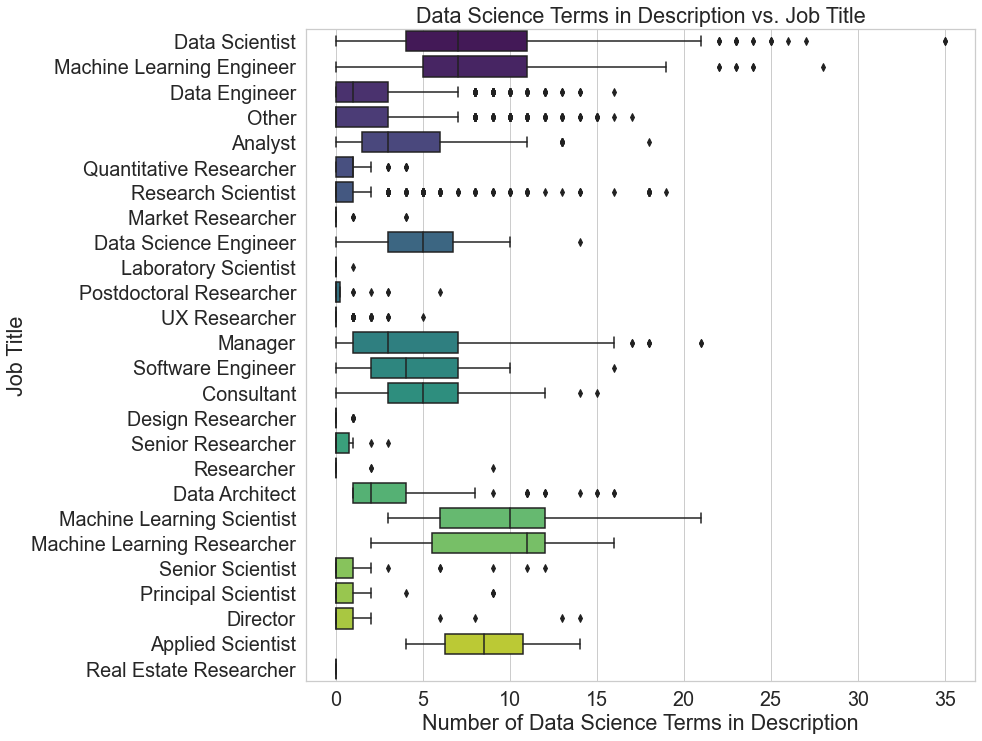

In [29]:
# examine the number of data science terms for different titles using boxplot

plt.figure(figsize = (12, 12))
sns.boxplot(x = data_1['Data Science Terms Count'], y = data_1['Job Title'], palette = 'viridis')
plt.xlabel('Number of Data Science Terms in Description')
plt.title('Data Science Terms in Description vs. Job Title')
plt.show()

- Job titles with the largest number of data science terms in the descriptions are: 
Data Scientist, Machine Learning Engineer, Machine Learning Scientist, Machine Learning Researcher, and Applied Scientist.
- Job titles with zero or very small number of data science terms in the descriptions are: 
Market Researcher, Laboratory Scientist, UX Researcher, Design Researcher, Researcher, and Real Estate Researcher.

This raises the question: How did our job search for 'Data Scientist' positions yielded results from the second group? Is it because ‘Researcher’ has close association with ‘Scientist’ or is there some other criterion? 

In general, one of the most prevalent observations from our job searches is that a significant number of the results were practically irrelevant to the search. To those with some knowledge and experience in this area, it is quite clear that a better search engine can be easily created. The question then is why it has not been done. This is not a characteristic of the LinkedIn search engine but of all job search engines of different sites we have tried.

In addition to the above distributions, it would also be informative to find the behavior of the average number of data science terms with job title.

In [30]:
# get the mean of data science terms for each job title
ds_terms_mean = [data_1[data_1['Job Title'] == title]['Data Science Terms Count'].mean() for title in data_1['Job Title']]

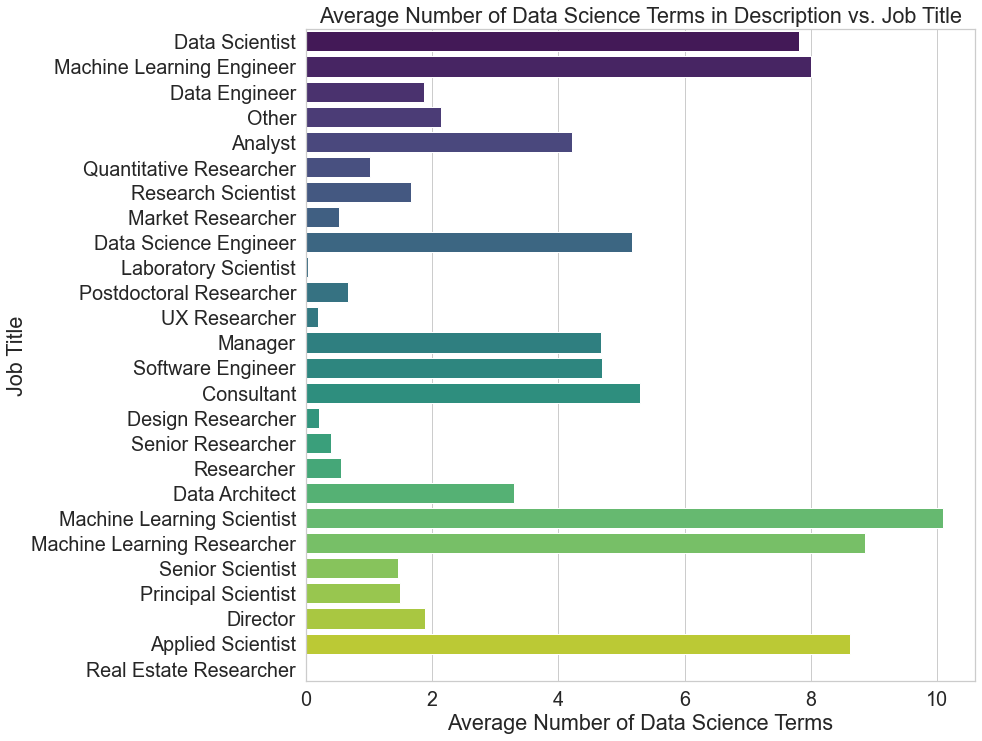

In [31]:
# plot the means

plt.figure(figsize = (12, 12))
sns.barplot(x = ds_terms_mean, y = data_1['Job Title'], palette = 'viridis')
plt.xlabel('Average Number of Data Science Terms')
plt.title('Average Number of Data Science Terms in Description vs. Job Title')

plt.show()

The average number of data science terms in the job description is consistent with the box plot results.

Finally, we would like to examine the histogram of the data science terms count.

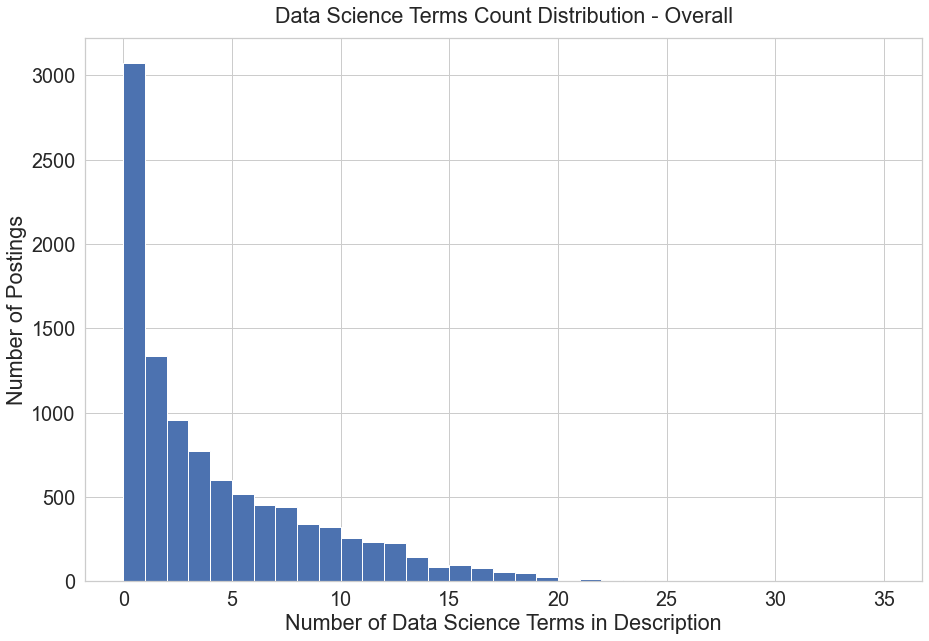

In [32]:
# for comparison with other cases, it is best to set an appropriate bin size for the histogram
# the number of bins will be derived based on the selected bin size as shown below

count_dst = data_1['Data Science Terms Count']

bin_size = 1
n_bins = int((count_dst.max() - count_dst.min()) // bin_size) # make sure to define it as an integer

plt.figure(figsize = (15, 10))
plt.hist(count_dst, bins = n_bins)
plt.xlabel('Number of Data Science Terms in Description')
plt.ylabel('Number of Postings')
plt.title('Data Science Terms Count Distribution - Overall', pad = 15)

plt.show()

As the histogram shows, an extremely large number of records have zero or very small number of data science terms in their description. It is therefore critical to eliminate the records which we believe to be irrelevant for our project. To us a threshold of three data science terms in the description is the minimum a  record has to meet in order to be considered relevant. 

The reason for selecting three data science terms is that during scraping we have witnessed many descriptions which read along these lines: "The data engineer will be working closely with the data science team to support various data science projects ...." Clearly, this is not a Data Scientist or any closely related position and yet it has two data science terms in its description.

In [33]:
# get the title counts for all records and for the ones with few data science terms in description

# all jobs
list_titles = list(data_1['Job Title'].value_counts().index) # titles of all jobs
titles_count_1 = list(data_1['Job Title'].value_counts().values) # their count values

# titles with 2 or less data science terms
title_count_ds = data_1[data_1['Data Science Terms Count'] < 3]['Job Title'].value_counts()

In [34]:
# the two counts do not neccesarily have the same titles in the same order
# since we want to plot these two on the same plot we need to match them

# create list of zeroes with size matching the size of all job titles
titles_count_2 = [0 for _ in range(len(list_titles))]

In [35]:
# fill the correct values for the titles with few ds terms

i_1 = -1
i_2 = -1
for item_1 in list_titles:
    i_1 += 1
    i_2 = -1
    
    for item_2 in title_count_ds.index:
        i_2 += 1
        
        if item_1 == item_2:
            titles_count_2[i_1] = title_count_ds.values[i_2]

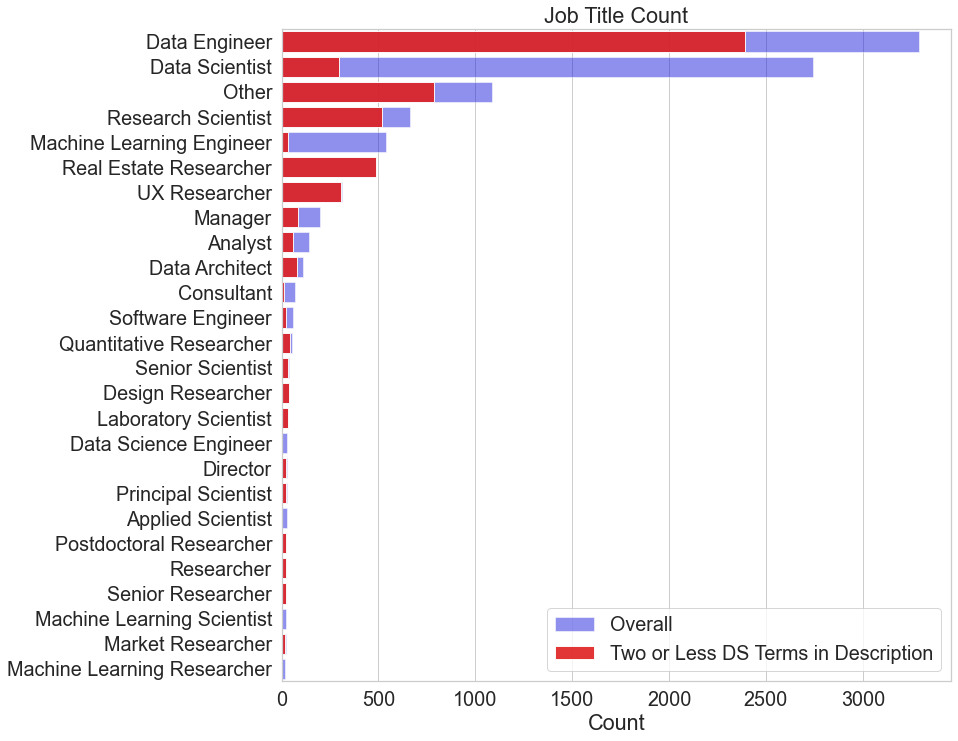

In [36]:
# plot both counts
plt.figure(figsize = (12, 12))
sns.barplot(x = titles_count_1, y = list_titles, color = 'blue', alpha = 0.5, label = 'Overall')
sns.barplot(x = titles_count_2, y = list_titles, color = 'red', alpha = 0.9, label = 'Two or Less DS Terms in Description')
plt.xlabel('Count')
plt.title('Job Title Count')

plt.legend(bbox_to_anchor=(1.0, 0.0), loc='lower right')
plt.show()

As seen from the plot, a significant number of postings for some job titles fall in the category of irrelevant postings. 'Data Engineer' is, perhaps, the most extreme example since it has the largest number of postings neqrly 3/4 of which do not pass the relevancy test. As mentioned above, we will eliminate these records. 

It is also notable that there are postings with the title of 'Data Scientist' which do not meet the data science terms count threshold. However, based on the title alone we will leave these records in the data.

In [37]:
# set the appropriate filter for jobs with titles different from Data Scientist and having few data science terms
mask_ds = (data_1['Job Title'] != 'Data Scientist') & (data_1['Data Science Terms Count'] < 3)

# apply filter and create a new data se, data_2
data_2 = data_1[~mask_ds] # elimnates all postings which satisfy the condition above
data_2.reset_index(inplace = True, drop = True)

data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5045 entries, 0 to 5044
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Job Title                 5045 non-null   object
 1   Company Name              5045 non-null   object
 2   Industry                  5045 non-null   object
 3   Job Function              5045 non-null   object
 4   Metro Area                5045 non-null   object
 5   Education-Bachelor        5045 non-null   int64 
 6   Education-Master          5045 non-null   int64 
 7   Education-Doctor          5045 non-null   int64 
 8   Minimum Experience        5045 non-null   int64 
 9   Seniority Level           5045 non-null   object
 10  Data Science Terms Count  5045 non-null   int64 
 11  Time Posted               5045 non-null   int64 
 12  Number of Applicants      5045 non-null   int64 
 13  Applicants per Day        5045 non-null   int32 
 14  Position Demand         

After eliminating the records which do not pass the relevancy threshold based on data science terms count, there are 5045 records left. We would like to examine again the histogram of the data science terms count after elimination.

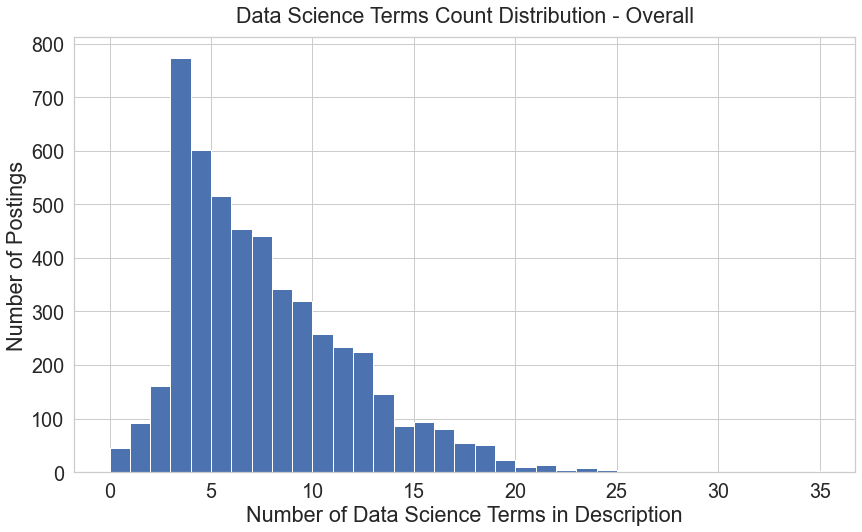

In [38]:
# plot again the distribution of data science terms
count_dst = data_2['Data Science Terms Count']

bin_size = 1
n_bins = int((count_dst.max() - count_dst.min()) // bin_size) # make sure to define it as an integer

plt.figure(figsize = (14, 8))
plt.hist(count_dst, bins = n_bins)

plt.xlabel('Number of Data Science Terms in Description')
plt.ylabel('Number of Postings')
plt.title('Data Science Terms Count Distribution - Overall', pad = 15)

plt.show()

As expected the distribution now is significantly different with the largest number of postings having three or four data science terms in their description. The remaining few records with a small number of data science terms belong to the few 'Data Scientist' positions which we discussed earlier.

In order to be able to use this feature for modeling it is more appropriate to separate the data entries into different classes with a particular range of data terms in the description. We will create a new feature 'Relevance Class' using the following segmentation:
- Class 1: 0-2 terms
- Class 2: 3-6 terms
- Class 3: 7-10 terms
- Class 4: 11- terms

In [39]:
# create new feature 'Relevance Rank'

data_2['Relevance Class'] = 0
data_2.head()

,Job Title,Company Name,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Minimum Experience,Seniority Level,Data Science Terms Count,Time Posted,Number of Applicants,Applicants per Day,Position Demand,Relevance Class
0,Data Scientist,Honeywell,Staffing and Recruiting,Engineering,ATL,0,1,1,2,entry,7,2,40,20,3,0
1,Data Scientist,SynergisticIT,Staffing and Recruiting,Information Technology,ATL,1,1,0,10,entry,2,1,0,25,3,0
2,Data Scientist,Inspire Brands,Financial Services,Engineering,ATL,0,0,0,1,entry,4,1,25,25,3,0
3,Data Scientist,The Home Depot,Financial Services,Engineering,ATL,0,1,0,2,entry,3,1,29,29,4,0
4,Data Scientist,Edelman Data & Intelligence (DxI),Research,Analyst,ATL,0,0,0,0,entry,3,1,0,25,3,0


In [40]:
# fill values appropriately

n_dst = 0

for i in range(len(data_2)):
    n_dst = data_2['Data Science Terms Count'][i]
    
    if n_dst < 3:
        data_2['Relevance Class'][i] = 1
    elif n_dst >= 3 and n_dst < 7:
        data_2['Relevance Class'][i] = 2
    elif n_dst >= 7 and n_dst < 11:
        data_2['Relevance Class'][i] = 3
    else:
        data_2['Relevance Class'][i] = 4

In [41]:
data_2.head()

,Job Title,Company Name,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Minimum Experience,Seniority Level,Data Science Terms Count,Time Posted,Number of Applicants,Applicants per Day,Position Demand,Relevance Class
0,Data Scientist,Honeywell,Staffing and Recruiting,Engineering,ATL,0,1,1,2,entry,7,2,40,20,3,3
1,Data Scientist,SynergisticIT,Staffing and Recruiting,Information Technology,ATL,1,1,0,10,entry,2,1,0,25,3,1
2,Data Scientist,Inspire Brands,Financial Services,Engineering,ATL,0,0,0,1,entry,4,1,25,25,3,2
3,Data Scientist,The Home Depot,Financial Services,Engineering,ATL,0,1,0,2,entry,3,1,29,29,4,2
4,Data Scientist,Edelman Data & Intelligence (DxI),Research,Analyst,ATL,0,0,0,0,entry,3,1,0,25,3,2


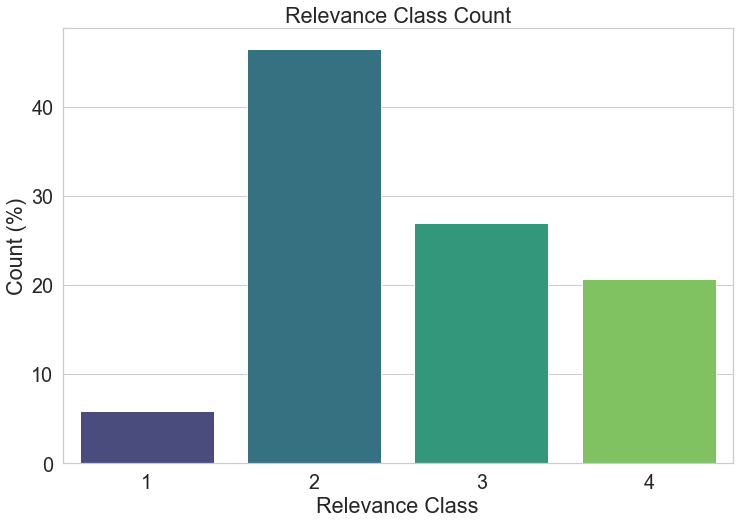

In [42]:
# get and plot 'Relevance' value count

count_relevance = data_2['Relevance Class'].value_counts(normalize = True) * 100

plt.figure(figsize = (12, 8))
sns.barplot(x = count_relevance.index, y = count_relevance.values, palette = 'viridis')
plt.xlabel('Relevance Class')
plt.ylabel('Count (%)')
plt.title('Relevance Class Count')
# plt.tick_params(axis = 'x', rotation = 90)
plt.show()

The resulting relevance classes count is as expected based on the distribution of the number of data science terms obtained above.

- **Company Name**

This is another feature which is pertinent to the relevance of different postings. That's why we will examine how many different companies are in the data and their relative contribution.

In [43]:
# get 'Company Name' count as percentage
count_company = data_2['Company Name'].value_counts(normalize = True) * 100

print(round(count_company, 2))

Dice                                        3.94
Amazon                                      2.66
Amazon Web Services (AWS)                   1.96
ClearanceJobs                               1.86
Harnham                                     1.59
                                            ... 
Stratacuity: Proven Scientific Placement    0.02
Showtime Networks Inc.                      0.02
Ursus, Inc.                                 0.02
Steward Health Care Network                 0.02
Alivia Analytics                            0.02
Name: Company Name, Length: 1531, dtype: float64


There are 1531 distinct company names. A feature with this many categorical values will create serious problems for our classification problem. We will examine the company names in more detail to see if we can reduce their number.

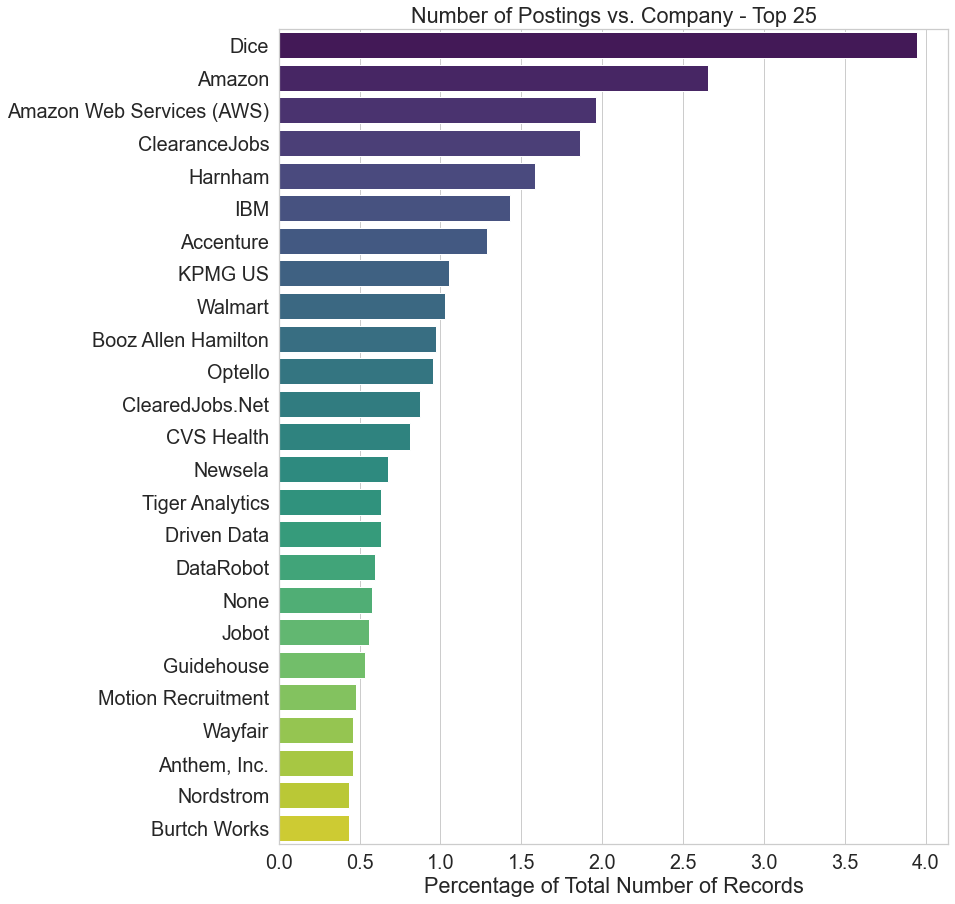

In [44]:
# plot the top 25

n_pts = 25

plt.figure(figsize = (12, 15))
sns.barplot(x = count_company.iloc[0:n_pts].values, y = count_company.iloc[0:n_pts].index, palette = 'viridis')
plt.xlabel('Percentage of Total Number of Records')
plt.title('Number of Postings vs. Company - Top ' + str(n_pts))
plt.show()

We note that Dice has the largest number of records in our data. Since it is another job search site and not a company which offers direct employment, the Dice postings are most likely redundant (duplicates of direct companies postings). Therefore, in order to avoid redundancy we will eliminate all Dice postings.

The second and third places are occupied by Amazon. Although Amazon Web Services is a part of Amazon, we will consider it as a separate entity due to the significant difference in the nature of its business. 

Among other highly represented companies we would like to note IBM, Walmart, Booz Allen Hamilton, and CVS. 

The rest of the companies in the graph is a mixture of large analytics consulting companies and staffing and recruiting companies.

In [45]:
# eliminate Dice
data_2 = data_2[data_2['Company Name'] != 'Dice']
data_2.reset_index(inplace = True, drop = True)

data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Job Title                 4846 non-null   object
 1   Company Name              4846 non-null   object
 2   Industry                  4846 non-null   object
 3   Job Function              4846 non-null   object
 4   Metro Area                4846 non-null   object
 5   Education-Bachelor        4846 non-null   int64 
 6   Education-Master          4846 non-null   int64 
 7   Education-Doctor          4846 non-null   int64 
 8   Minimum Experience        4846 non-null   int64 
 9   Seniority Level           4846 non-null   object
 10  Data Science Terms Count  4846 non-null   int64 
 11  Time Posted               4846 non-null   int64 
 12  Number of Applicants      4846 non-null   int64 
 13  Applicants per Day        4846 non-null   int32 
 14  Position Demand         

We have also noticed that there are records with a company name 'None'. We would like to examine some of these records more closely.

In [46]:
data_2[data_2['Company Name'] == 'None'].iloc[0:10, :]

,Job Title,Company Name,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Minimum Experience,Seniority Level,Data Science Terms Count,Time Posted,Number of Applicants,Applicants per Day,Position Demand,Relevance Class
58,Data Scientist,None,Engineering,Full-time,CHI,0,0,0,5,entry,2,2,49,24,3,1
422,Other,None,Biotechnology,Engineering,NY,0,1,0,3,associate,4,6,200,33,4,2
651,Data Scientist,None,Internet,Engineering,NY,0,1,0,3,senior,13,3,0,8,2,4
802,Data Scientist,None,Biotechnology,Engineering,BOS,0,0,1,0,entry,4,3,200,66,4,2
1193,Other,None,Biotechnology,Engineering,NY,0,1,0,3,associate,4,6,200,33,4,2
1238,Data Scientist,None,Computer Software,Marketing,SEA,1,1,0,6,associate,10,4,52,13,3,3
1408,Data Scientist,None,Other,Management,DC,0,1,1,5,senior,9,3,0,8,2,3
1452,Machine Learning Engineer,None,Staffing and Recruiting,Engineering,NY,0,0,0,5,senior,4,2,200,100,4,2
1497,Machine Learning Engineer,None,Transportation,Information Technology,PHX,1,1,0,5,senior,3,2,0,12,2,2
1634,Other,None,Other,Full-time,BOS,0,1,0,5,entry,3,4,0,6,1,2


The information in these records seems fine. These records are most likely postings by staffing and recruiting companies which do not want to reveal the company name. So, we will keep these entries, but will replace 'None' with 'Other' for the company name.

In [47]:
# repalce 'None' with 'Other'

data_2.replace('None', 'Other', inplace = True)

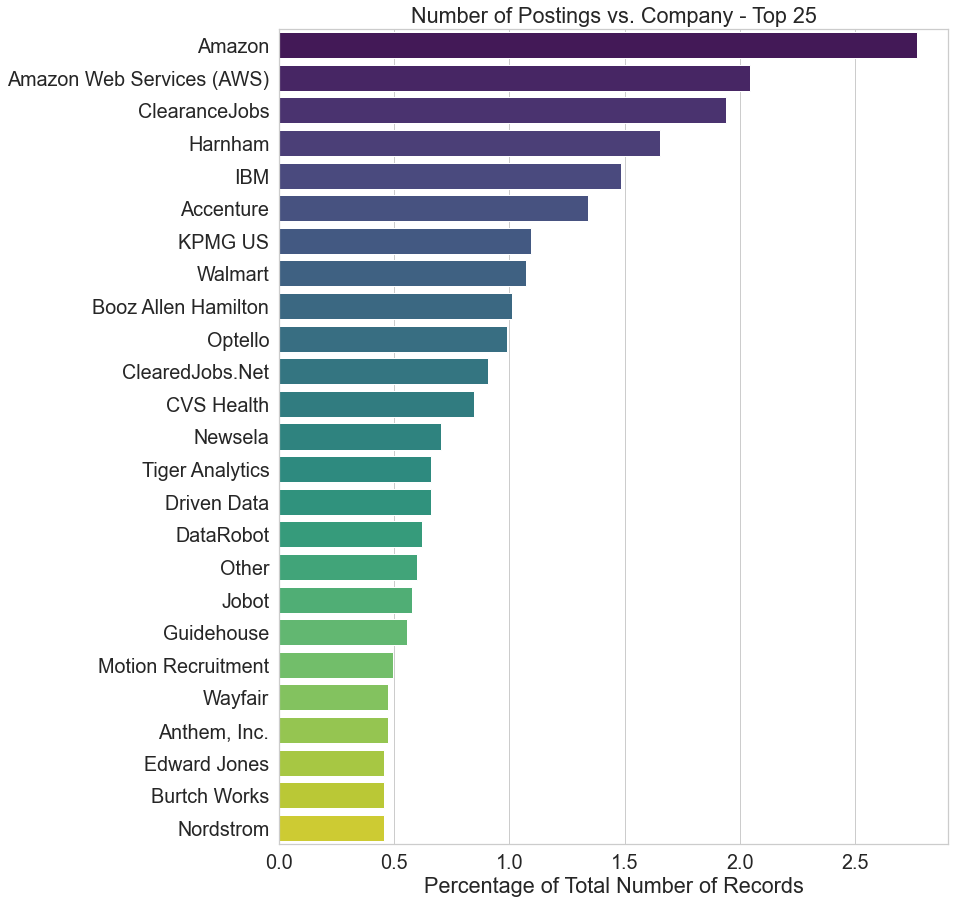

In [48]:
# plot again

count_company = data_2['Company Name'].value_counts(normalize = True) * 100

n_pts = 25

plt.figure(figsize = (12, 15))
sns.barplot(x = count_company.iloc[0:n_pts].values, y = count_company.iloc[0:n_pts].index, palette = 'viridis')
plt.xlabel('Percentage of Total Number of Records')
plt.title('Number of Postings vs. Company - Top ' + str(n_pts))
plt.show()

We would like to examine the number of companies above and below the 0.1% threshold, and their contribution to the remaining data.

In [49]:
# print the companies above the 0.1% threshold

print(round(count_company[count_company.values >= 0.1], 2))
print('\n')
print('Number of companies above the 0.1% threshold: ', len(count_company[count_company.values > 0.1]))
print('Percentage of all records: ', round(sum(count_company[count_company.values > 0.1].values), 2))

Amazon                           2.77
Amazon Web Services (AWS)        2.04
ClearanceJobs                    1.94
Harnham                          1.65
IBM                              1.49
                                 ... 
TEKsystems                       0.10
Nuna Inc.                        0.10
Getty Images                     0.10
Money Mart Financial Services    0.10
Cox Communications               0.10
Name: Company Name, Length: 195, dtype: float64


Number of companies above the 0.1% threshold:  195
Percentage of all records:  54.91


In [50]:
# print the companies below the 0.1% threshold

print(round(count_company[count_company.values < 0.1], 2))
print('\n')
print('Number of companies below the 0.1% threshold: ', len(count_company[count_company.values < 0.1]))
print('Percentage of all records: ', round(sum(count_company[count_company.values < 0.1].values), 2))

Genuent                                     0.08
Mathematica                                 0.08
Cloudflare                                  0.08
Insight                                     0.08
INDUS Technology, Inc.                      0.08
                                            ... 
Stratacuity: Proven Scientific Placement    0.02
Showtime Networks Inc.                      0.02
Ursus, Inc.                                 0.02
Steward Health Care Network                 0.02
Alivia Analytics                            0.02
Name: Company Name, Length: 1335, dtype: float64


Number of companies below the 0.1% threshold:  1335
Percentage of all records:  45.09


There are 195 companies above the 0.1% threshold which represent 55% of all records. The number of companies below the 0.1% threshold is 1335 and represent 45% of all remaining data. Because of this, it would not be appropriate to combine companies below the 0.1% threshold. This leaves us with too large a number of companies which makes this feature not suitable for using in the data modeling.

Still, it is interesting to see where some companies stand in the Least- and Most-demand categories. Because of the large number of companies we will limit our examination to the top 25.

In [51]:
# define a function to plot the ratio of items in least demand to total number of items
# function will be used for various data features

data_feat = 'Company Name'
fig_size_x = 15
fig_size_y = 18

x_min = 0
x_max = 100
d_x = 10

plt_pts = 25 # option to limit the number of points to plot

def plot_demand_least(data, data_feat, fig_size_x, fig_size_y, x_min, x_max, d_x, plt_pts):
    list_feat = data[data_feat].value_counts().index
    
    r_demand = np.zeros(len(list_feat))
    i_r = 0
    
    for item in list_feat:
        r_demand[i_r] = len(data[data[data_feat] == item][data['Position Demand'] == 1]) / len(data[data[data_feat] == item])
        i_r += 1
        
    plt.figure(figsize = (fig_size_x, fig_size_y))
    sns.barplot(x = r_demand[0:plt_pts] * 100, y = list_feat[0:plt_pts], palette = 'viridis')
    plt.xlim(x_min, x_max)
    plt.xticks(np.arange(x_min, x_max + d_x , d_x))
    plt.xlabel('Number of Posts with Least Demand / Total Number of Posts (%)')
    plt.title('Percentage of Posts with Least Demand Relative to Total Number of Posts for a Particular ' + data_feat, pad = 20)

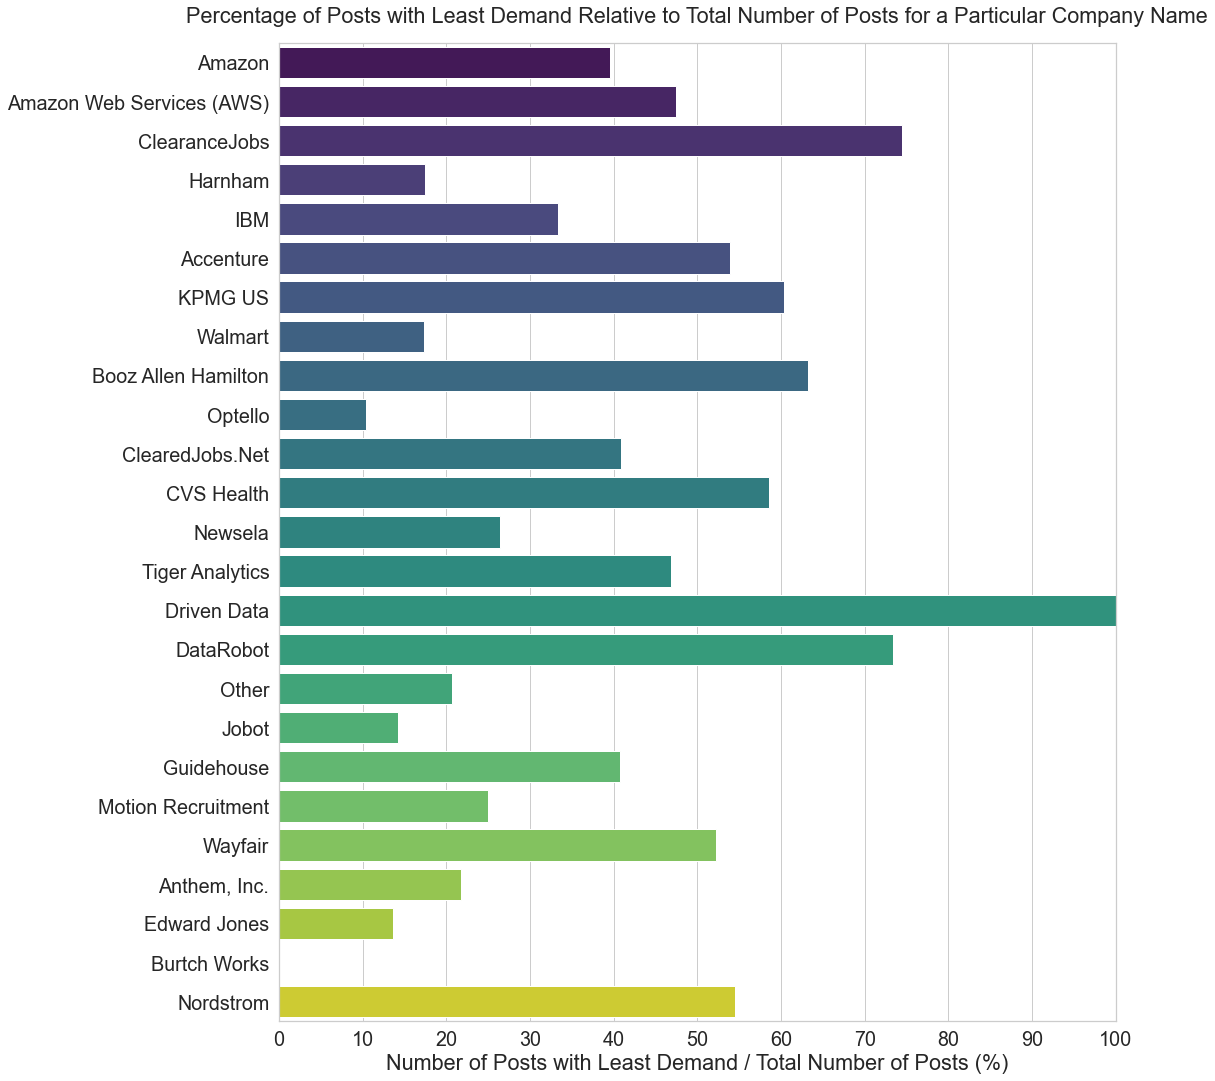

In [52]:
plot_demand_least(data_2, data_feat, fig_size_x, fig_size_y, x_min, x_max, d_x, plt_pts)

Observations:
- Companies with very large percentage of postings with six or less applicants per day are ClearenceJobs, Driven Data, and DataRobot. We believe that these are staffing and recruiting companies or "mini-Dice" which do not hire directly and have a redunduncy of job postings. We should pay special attention to these companies in the model predictions.
- Companies which are of interest to us and have relatively large percentage of postings with six or less applicants per day are Amazon, IBM, Booz Allen Hamilton, and CVS
- Companies which are of interest to us and have small percentage of postings with six or less applicants per day are Walmart and Edward Jones

In [53]:
# define a function to plot the ratio of items in most demand to total number of items
# function will be used for various data features

def plot_demand_most(data, data_feat, fig_size_x, fig_size_y, x_min, x_max, d_x, plt_pts):
    list_feat = data[data_feat].value_counts().index
    
    r_demand = np.zeros(len(list_feat))
    i_r = 0
    
    for item in list_feat:
        r_demand[i_r] = len(data[data[data_feat] == item][data['Position Demand'] == 4]) / len(data[data[data_feat] == item])
        i_r += 1
        
    plt.figure(figsize = (fig_size_x, fig_size_y))
    sns.barplot(x = r_demand[0:plt_pts] * 100, y = list_feat[0:plt_pts], palette = 'viridis')
    plt.xlim(x_min, x_max)
    plt.xticks(np.arange(x_min, x_max + d_x , d_x))
    plt.xlabel('Number of Posts with Most Demand / Total Number of Posts (%)')
    plt.title('Percentage of Posts with Most Demand Relative to Total Number of Posts for a Particular ' + data_feat, pad = 20)

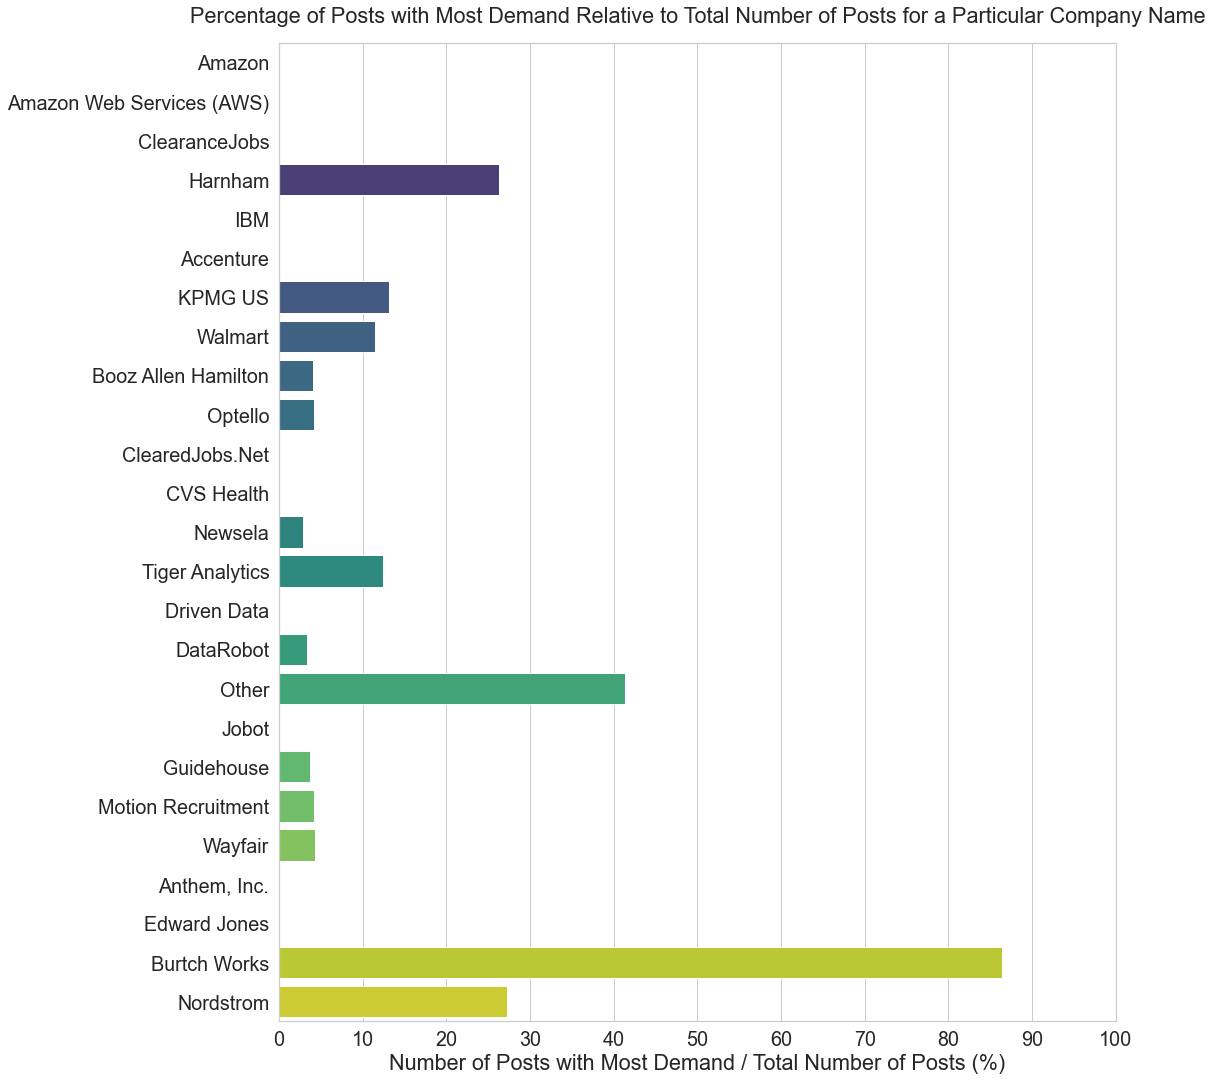

In [54]:
plot_demand_most(data_2, data_feat, fig_size_x, fig_size_y, x_min, x_max, d_x, plt_pts)

The main observation here is that there are very few companies with more than 25 applicants per day which is naturally to expect. The only notable exception is Burtch Works for which approximately 87% of the postings are in the most applicants per day category.

- **Job Title**

We would like to examine the 'Job Title' composition after the data has been filtered by relevance and company name.

In [55]:
# get and plot 'Job Title' value count

count_title = data_2['Job Title'].value_counts()

print(count_title)
print('\n')
print('Number of job titles: ', len(count_title))

Data Scientist                 2644
Data Engineer                   838
Machine Learning Engineer       487
Other                           293
Research Scientist              146
Manager                         113
Analyst                          81
Consultant                       55
Software Engineer                37
Data Architect                   35
Applied Scientist                26
Data Science Engineer            22
Machine Learning Scientist       20
Machine Learning Researcher      16
Quantitative Researcher           8
Senior Scientist                  6
UX Researcher                     4
Principal Scientist               4
Director                          4
Postdoctoral Researcher           3
Market Researcher                 2
Senior Researcher                 1
Researcher                        1
Name: Job Title, dtype: int64


Number of job titles:  23


Since Machine Learning Scientist and Machine Learning Researcher are of interest to us and appear similar, we will bundle them in one as 'ML Specialist'. However , we will keep them separate from Machine Learning Engineer. Similarly, we will combine the titles of ‘Senior Scientist’ and  'Principal Scientist' in one as ‘Scientist’; ‘Senior Researcher’ and 'Researcher' in one as 'Researcher'. Researchers in different areas will be kept independently.

In [56]:
# replace the above mentioned titles

dict_title_replace = {'Machine Learning Engineer': 'ML Engineer', 
                      'Machine Learning Scientist': 'ML Specialist', 
                      'Machine Learning Researcher': 'ML Specialist', 
                      'Senior Scientist':'Scientist', 
                      'Principal Scientist':'Scientist', 
                      'Senior Researcher':'Researcher'}

data_2['Job Title'].replace(dict_title_replace, inplace=True)

In [57]:
# get and print the new 'Job Title' value count

count_title = data_2['Job Title'].value_counts()

print(count_title)
print('\n')
print('Number of job titles: ', len(count_title))

Data Scientist             2644
Data Engineer               838
ML Engineer                 487
Other                       293
Research Scientist          146
Manager                     113
Analyst                      81
Consultant                   55
Software Engineer            37
ML Specialist                36
Data Architect               35
Applied Scientist            26
Data Science Engineer        22
Scientist                    10
Quantitative Researcher       8
UX Researcher                 4
Director                      4
Postdoctoral Researcher       3
Market Researcher             2
Researcher                    2
Name: Job Title, dtype: int64


Number of job titles:  20


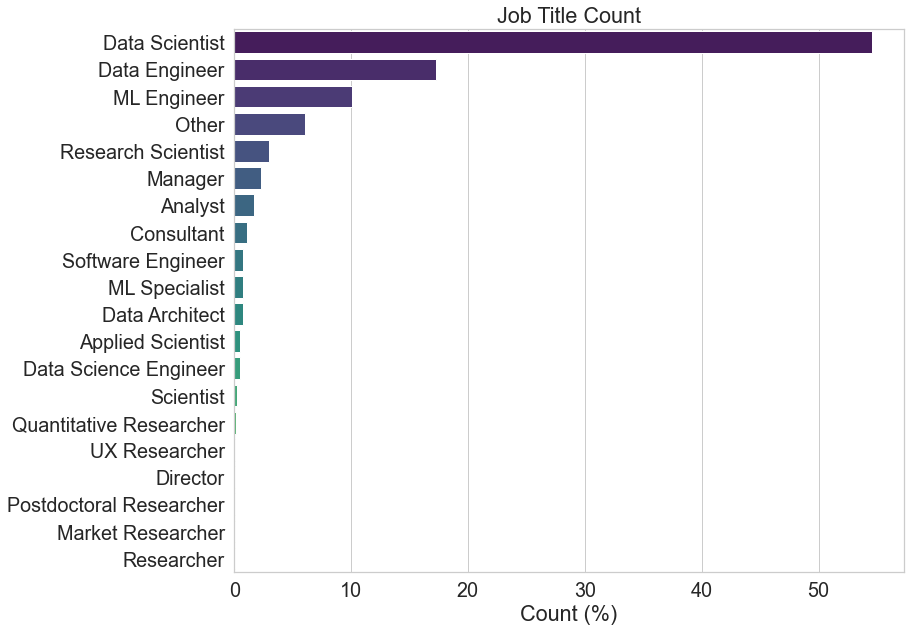

In [58]:
# plot job titles count in percents

count_title = data_2['Job Title'].value_counts(normalize = True) * 100

plt.figure(figsize = (12, 10))
sns.barplot(x = count_title.values, y = count_title.index, palette = 'viridis')
plt.xlabel('Count (%)')
plt.title('Job Title Count')

plt.show()

We are left with 20 job titles which will be included in the modeling. 'Data Scientist' is as expected by far the most common title representing approximately 57% of all records. Despite eliminating so many of the 'Data Engineer' postings, they are in second place at about 18% of all data. 'Machine Learning Engineer' is in third place at 10%.

At this point, we would like to examine which titles are in least and most demand - Demand Class 1 and Demand Class 4, respectively.

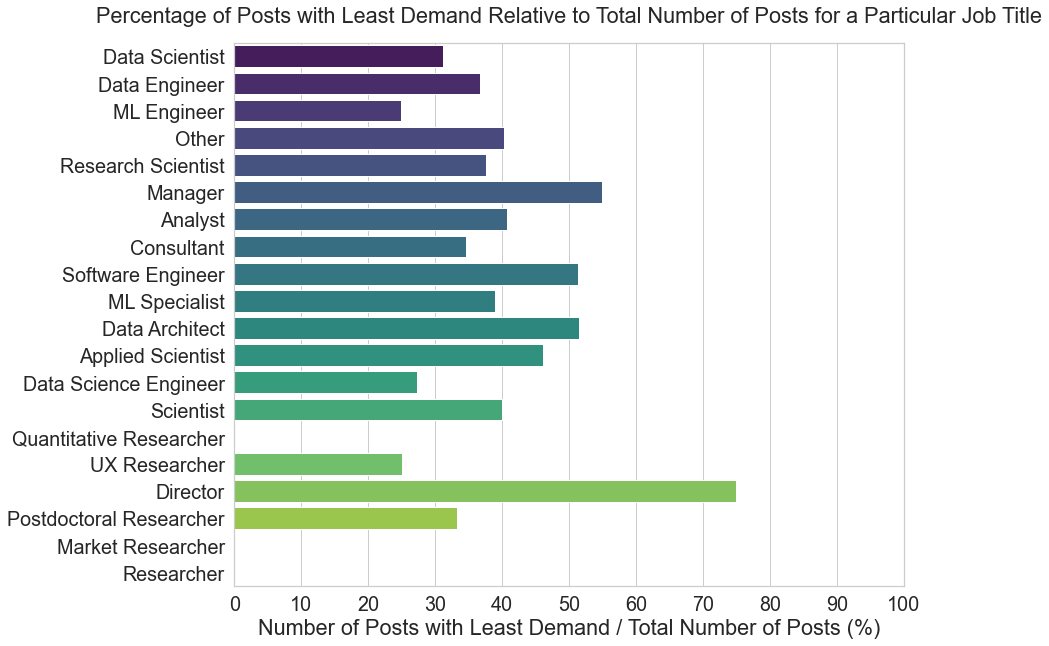

In [59]:
data_feat = 'Job Title'

fig_size_x = 12
fig_size_y = 10
x_max = 100
d_x = 10
plt_pts = 20

plot_demand_least(data_2, data_feat, fig_size_x, fig_size_y, x_min, x_max, d_x, plt_pts)

Main observations for posts with five or less applicants per day (low demand):
- The top three job titles have approximately 20% of posts in this category. 
- Manager and Director have approximately 45 and 50% of posts in this category, respectively.
- It is worth noting that a large percentage (~40%) of posts for Applied Scientist, a position with high relevance rank, also belong to this category.
- On the other hand, there are no postings for any of the job titles which include 'Researcher' in this category.

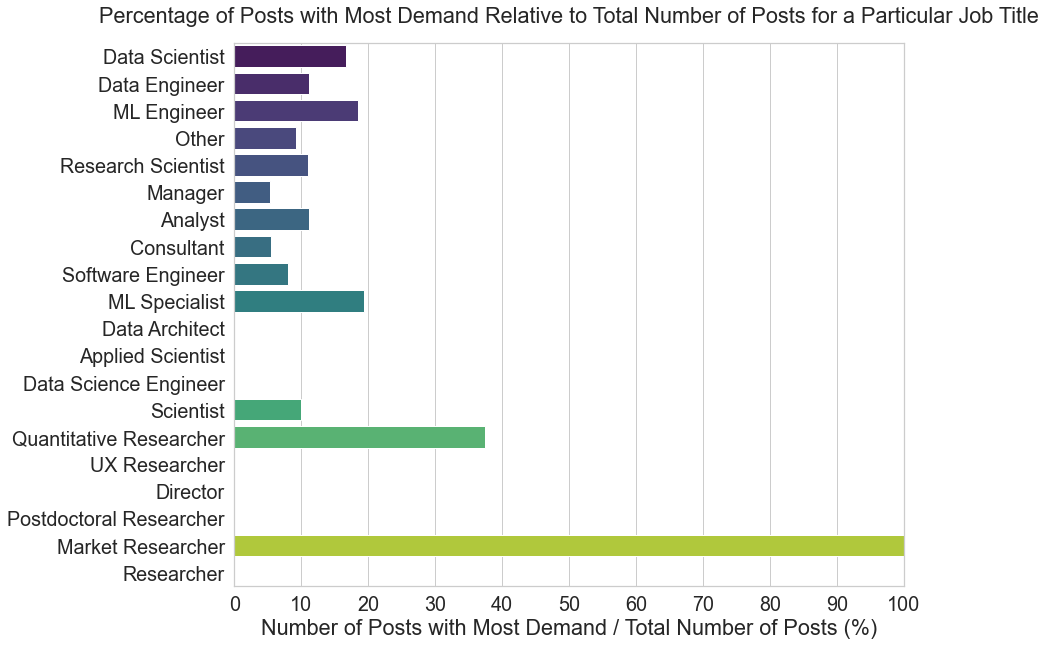

In [60]:
plot_demand_most(data_2, data_feat, fig_size_x, fig_size_y, x_min, x_max, d_x, plt_pts)

Main observations for posts with 26 or more applicants per day (high demand):
- All postings for Market Researcher are in the high demand category (note that there are only two posts with this job title). 
- Quantitative Researcher is second with approximately 38% of posts in this category.
- Applied Scientist which was noted in the low demand plot has no posts in the high demand category. Although the total number of posts for Applied Scientist is small (26), these positions deserve our interest.
- The top three job titles on the other hand have relatively low (below 20%) number of posts in the high demand category which is also a positive news for us.

- **Industry**

Examine the industry values.

In [61]:
# get 'Industry' count as percentage
count_industry = data['Industry'].value_counts(normalize = True) * 100
print(round(count_industry, 2))
print('\n')
print('Nimber of industries: ', len(count_industry))

Financial Services                     19.75
Internet                               11.52
Marketing and Advertising               9.93
Health Care                             8.50
Real Estate                             5.33
Biotechnology                           4.79
Computer Software                       4.79
Staffing and Recruiting                 4.51
Management Consulting                   3.47
Information Technology and Services     3.32
Defense                                 3.28
Banking                                 2.68
Insurance                               1.95
Research                                1.53
Network Security                        1.28
Education                               1.27
Other                                   1.15
Manufacturing                           1.14
Telecommunications                      1.05
Retail                                  0.91
Automotive                              0.83
Pharmaceutical                          0.67
Constructi

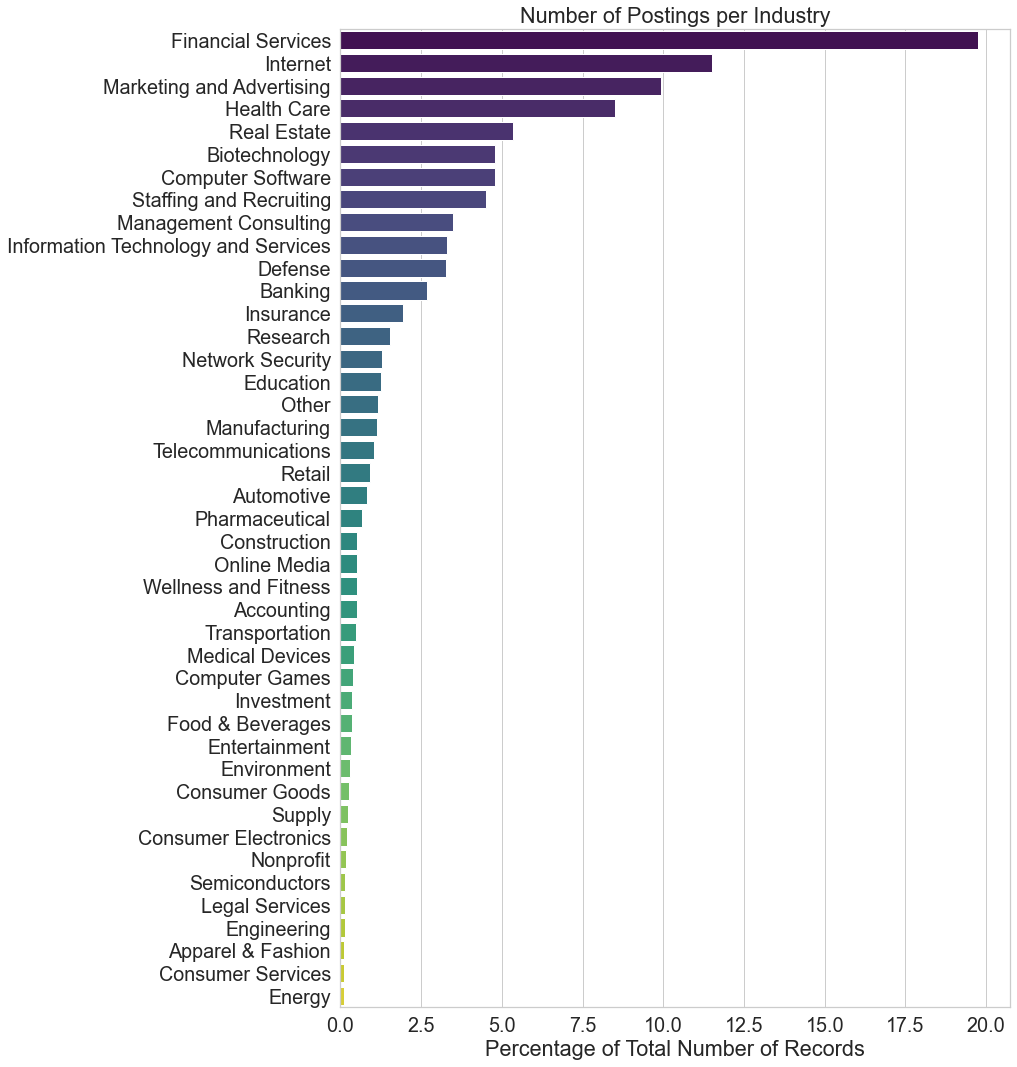

In [62]:
# visualize in a plot

plt.figure(figsize = (12, 18))
sns.barplot(x = count_industry.values, y = count_industry.index, palette = 'viridis')
plt.xlabel('Percentage of Total Number of Records')
plt.title('Number of Postings per Industry')
plt.show()

There are 43 distinct industries. The leading four in postings by a significant margin in comparison with the rest are: 'Financial Services', 'Internet', 'Marketing and Advertising', and 'Health Care'.

It would be interesting to see how they place in the low- and high-demand categories.

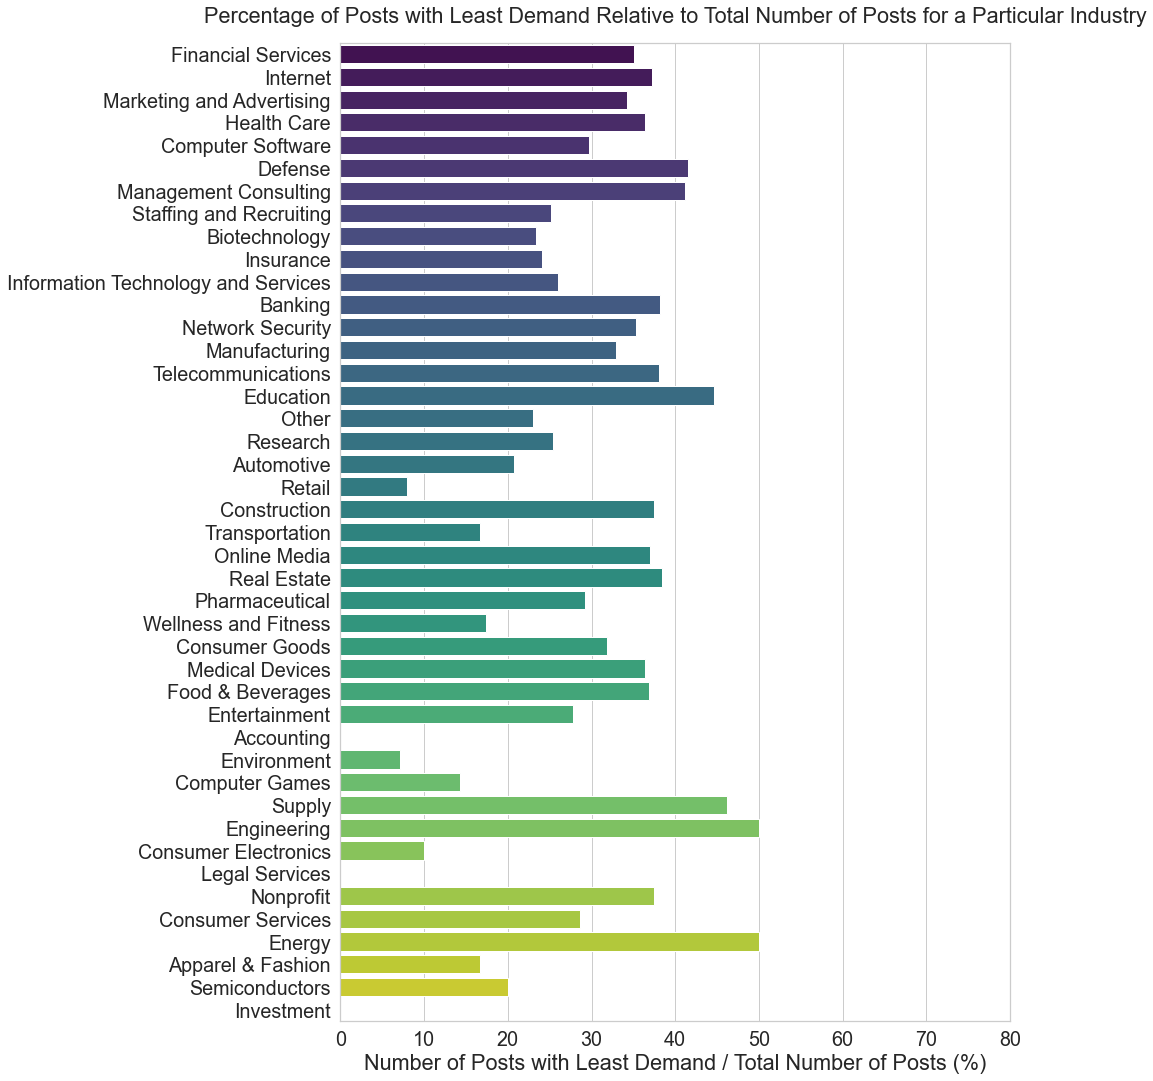

In [63]:
# plot low demand postings

data_feat = 'Industry'
fig_size_x = 12
fig_size_y = 18
x_max = 80
d_x = 10
plt_pts = 43

plot_demand_least(data_2, data_feat, fig_size_x, fig_size_y, x_min, x_max, d_x, plt_pts)

The top four industries have a substantial portion of postings - between 20 and 30% - which have five or less applicants per day.

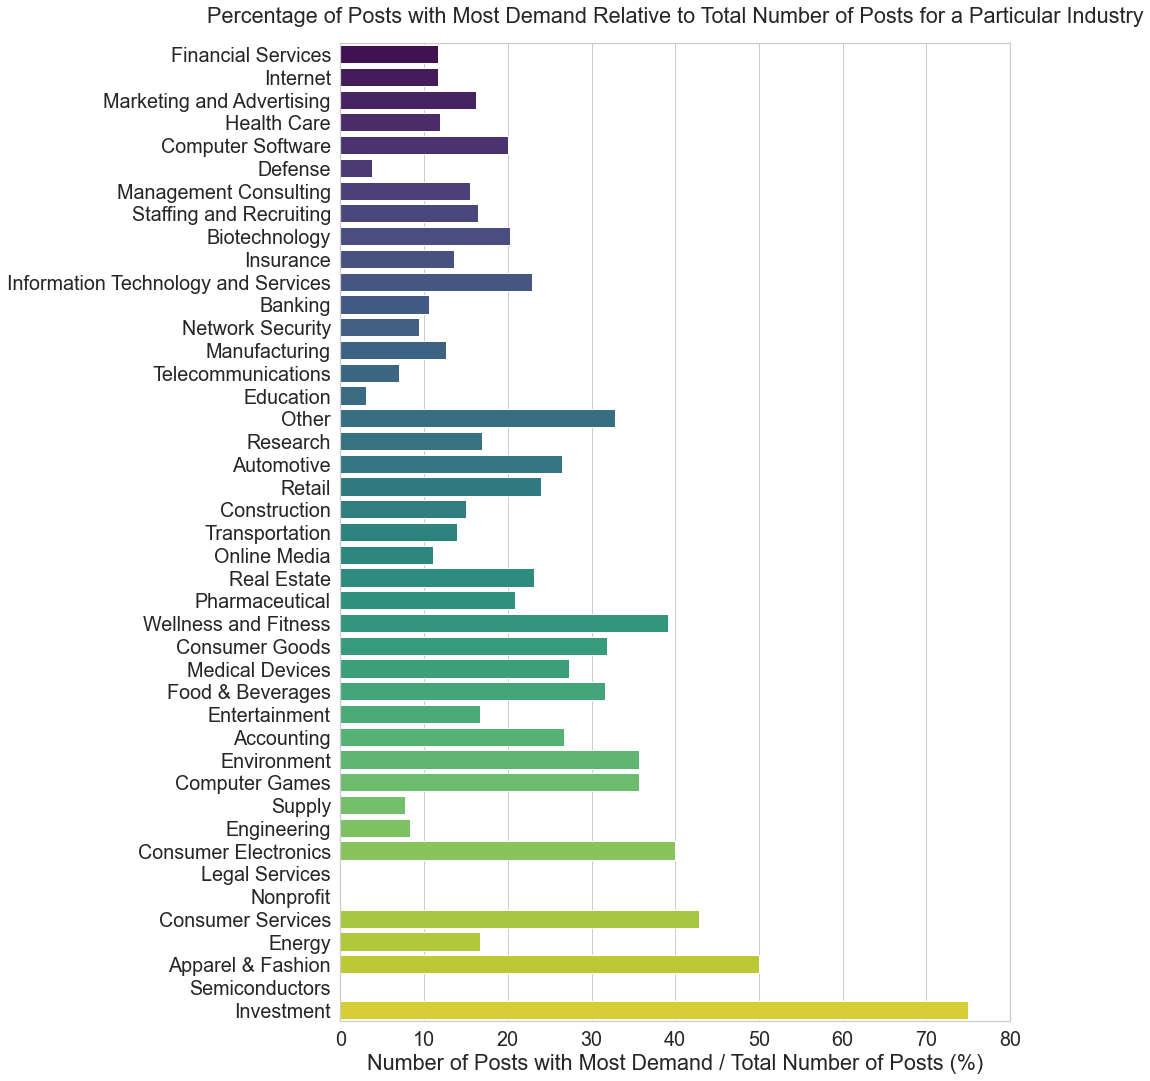

In [64]:
# plot high demand postings
x_max = 80
plot_demand_most(data_2, data_feat, fig_size_x, fig_size_y, x_min, x_max, d_x, plt_pts)

The top four industries have a relatively small number of postings with more than 25 applicants per day - between 10 and 20%.

- **Job Function**

Examine the 'Job Function' values.

In [65]:
# get 'Job Function' count as percentages

count_job_func = data['Job Function'].value_counts(normalize = True) * 100
print(round(count_job_func, 2))
print('\n')
print('Number of different job functions: ', len(count_job_func))

Information Technology    30.63
Engineering               25.78
Analyst                   13.35
Other                     11.76
Research                   4.62
Sales                      2.50
Consulting                 1.60
Marketing                  1.20
General Business           1.14
Finance                    1.14
Management                 1.14
Science                    0.97
Full-time                  0.68
Education                  0.56
Design                     0.54
Art                        0.53
Human Resources            0.33
Health Care                0.31
Manufacturing              0.26
Business Development       0.23
Supply Chain               0.20
Legal                      0.14
Advertising                0.12
Accounting                 0.09
Quality Assurance          0.08
Administrative             0.04
Associate                  0.02
Customer Service           0.01
Production                 0.01
Strategy/Planning          0.01
Name: Job Function, dtype: float64


Num

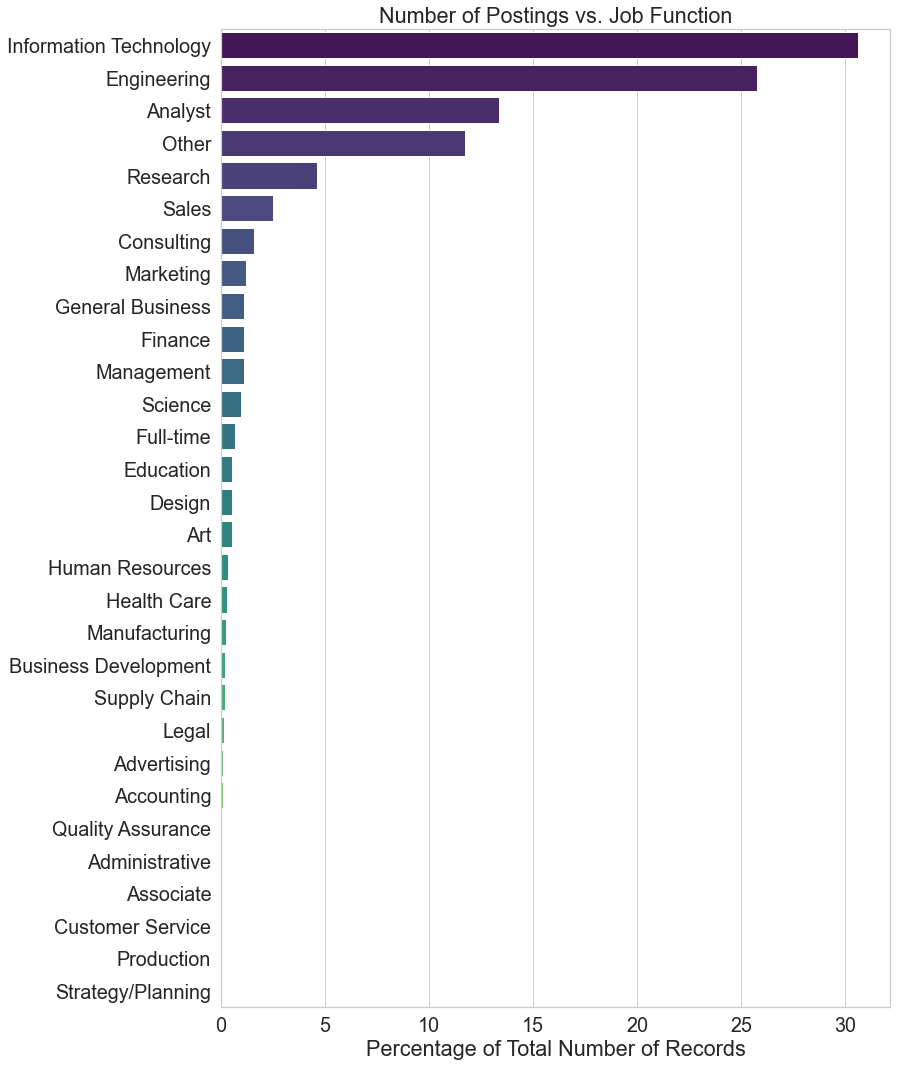

In [66]:
# visualize in a plot

plt.figure(figsize = (12, 18))
sns.barplot(x = count_job_func.values, y = count_job_func.index, palette = 'viridis')
plt.xlabel('Percentage of Total Number of Records')
plt.title('Number of Postings vs. Job Function')
plt.show()

There are 30 different job functions which will be used in the model.

- **'Minimum Experience'**

In [67]:
# get the value count for different years of experience
print('Years  Count')
print(data_2['Minimum Experience'].value_counts())

Years  Count
0      1314
2       841
3       824
5       787
4       337
1       241
6       136
10      121
7       101
8        66
15       12
20       10
200       9
50        8
9         7
25        6
12        5
55        3
160       3
18        3
13        2
180       2
148       2
45        1
89        1
40        1
329       1
22        1
75        1
Name: Minimum Experience, dtype: int64


Two types of values here deserve our attention. 
- The first is the 0 years of experience. These values can be attributed to either experience not being mentioned in the description or that the search pattern did not match the phrase used in the text.
- The second is the large values (e.g. 20, 50, 160 etc.) which are clearly not related to the experience required. These most likely refer to the number of years of the company being in business or having a team with a certain number of combined years of experience.

Both of these values will be replaced with the appropriate average values depending on metro area and seniority level.

In [68]:
# list for 'Metro Area'
list_metro = data_2['Metro Area'].value_counts().index
list_metro

Index(['DC', 'NY', 'SF', 'BOS', 'SEA', 'CHI', 'LA', 'ATL', 'DAL', 'AUS', 'PHI',
       'PHX', 'HOU', 'SD', 'POR', 'NC'],
      dtype='object')

In [69]:
# list for 'Seniority Level'
list_seniority = data_2['Seniority Level'].value_counts().index
list_seniority

Index(['senior', 'entry', 'associate'], dtype='object')

In [70]:
# fill 'Minimum Experience' values accordingly

for item_1 in list_metro:
    
    for item_2 in list_seniority:
        
        # create a filter with 'Minimum Experience' of 0 or greater than 10
        mask_exp = (data_2['Metro Area'] == item_1) & (data_2['Seniority Level'] == item_2) & (data_2['Minimum Experience'] == 0) | (data_2['Minimum Experience'] > 10)
        
        min_exp = np.array(data_2['Minimum Experience'][~mask_exp]) # get the rest of experience values
        min_exp = min_exp.mean()

        # we want to assign integer values as minimum experience - check if min_exp < 0.6 and assign 1
        if min_exp < 0.6:
              data_2['Minimum Experience'][mask_exp] = 1
        else:
              data_2['Minimum Experience'][mask_exp] = int(round(min_exp, 0))

In [71]:
# check
count_exp = data_2['Minimum Experience'].value_counts()
print(count_exp)

3     2126
2      841
5      787
4      420
1      241
6      136
10     121
7      101
8       66
9        7
Name: Minimum Experience, dtype: int64


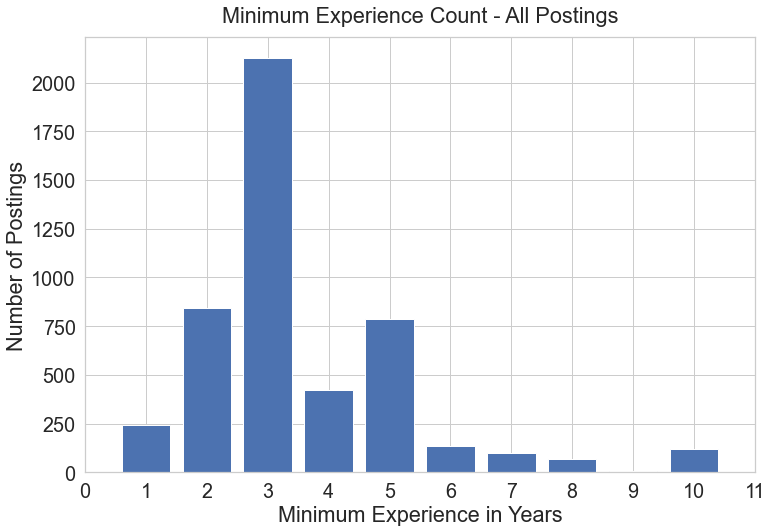

In [72]:
# visualize in a barplot

d_x = 1
x_min = 0
x_max = count_exp.index.max() + d_x
x_ticks = np.arange(x_min, x_max + d_x, d_x)


plt.figure(figsize = (12, 8))
plt.bar(count_exp.index, count_exp.values)
plt.xticks(x_ticks)
plt.xlabel('Minimum Experience in Years')
plt.ylabel('Number of Postings')
plt.title('Minimum Experience Count - All Postings', pad = 15)

plt.show()

The most oftenly occured minimum experience is three years, followed by two and five years.

It would be interesting to see what the differences are depending on seniority level.

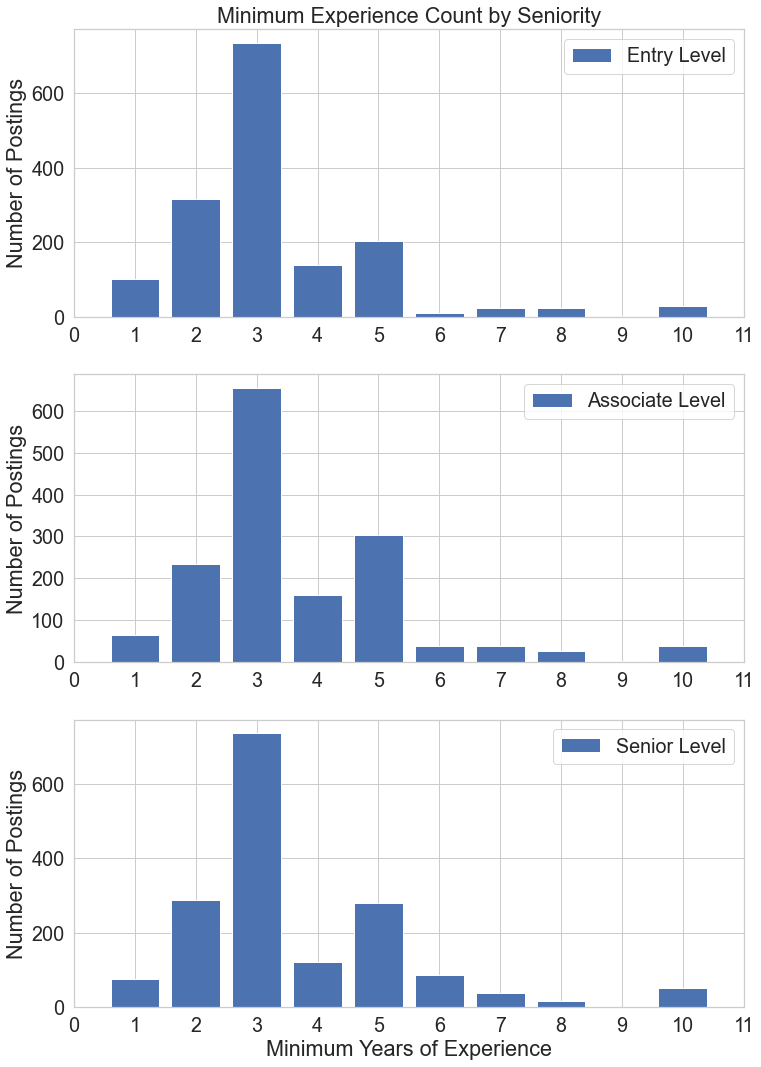

In [73]:
# entry level
count_exp_1 = data_2[data_2['Seniority Level'] == 'entry']['Minimum Experience'].value_counts()
# associate level
count_exp_2 = data_2[data_2['Seniority Level'] == 'associate']['Minimum Experience'].value_counts()
# senior level
count_exp_3 = data_2[data_2['Seniority Level'] == 'senior']['Minimum Experience'].value_counts()

fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharey = False)

axes[0].bar(count_exp_1.index, count_exp_1.values, label = 'Entry Level')
axes[0].set_xlim(x_min, x_max)
axes[0].set_xticks(x_ticks)
axes[0].set(ylabel = 'Number of Postings')
axes[0].set(title = 'Minimum Experience Count by Seniority')
axes[0].legend()

axes[1].bar(count_exp_2.index, count_exp_2.values, label = 'Associate Level')
axes[1].set_xlim(x_min, x_max)
axes[1].set_xticks(x_ticks)
axes[1].set(ylabel = 'Number of Postings')
axes[1].legend()

axes[2].bar(count_exp_3.index, count_exp_3.values, label = 'Senior Level')
axes[2].set_xlim(x_min, x_max)
axes[2].set_xticks(x_ticks)
axes[2].set(xlabel = 'Minimum Years of Experience')
axes[2].set(ylabel = 'Number of Postings')
axes[2].legend()

plt.show()

Surprisingly, the minimum experience patterns for different seniority levels are very similar. 

There are a couple of reasons which we could think of that could be responsible for these results.
- In many job descriptions, years of experience vary depending on the level of education - for example 5 years for a BS degree, 3 years for an MS degree and 1 year for a PhD degree. 
- In addition, some descriptions include different experience requirements for different skills - for example different programing languages, machine learning vs. data analytics experience, etc. Thus, selecting the minimum from a collection of different experience requirements as we have done would not capture accurately the actual requirement for the position.


**Overall, the minimum experience values extracted from the scraped data are ambiguous and might be misleading in distinguishing between positions with different seniority levels and other different features. That’s why we will not include ‘Minimum Experience’ in our data modeling.**

- **'Education Requirements'**

In [74]:
data_2.head()

,Job Title,Company Name,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Minimum Experience,Seniority Level,Data Science Terms Count,Time Posted,Number of Applicants,Applicants per Day,Position Demand,Relevance Class
0,Data Scientist,Honeywell,Staffing and Recruiting,Engineering,ATL,0,1,1,2,entry,7,2,40,20,3,3
1,Data Scientist,SynergisticIT,Staffing and Recruiting,Information Technology,ATL,1,1,0,10,entry,2,1,0,25,3,1
2,Data Scientist,Inspire Brands,Financial Services,Engineering,ATL,0,0,0,1,entry,4,1,25,25,3,2
3,Data Scientist,The Home Depot,Financial Services,Engineering,ATL,0,1,0,2,entry,3,1,29,29,4,2
4,Data Scientist,Edelman Data & Intelligence (DxI),Research,Analyst,ATL,0,0,0,3,entry,3,1,0,25,3,2


From the data, one can see that there are postings in which no match for education requirement was found during scraping. Although it is natural to assume that there is a certain education requirement for any position, we will not try to fill the missing values, but will leave these postings as if they represent a separate group in regards with education. The reason is that we want to create a model in which we can input data scraped daily. It is reasonable to expect that the daily postings will have a small number and therefore any scheme we use here for imputing education requirements based on the large amount of data collected is not expected to work well with a small sample. 

That’s why we will only examine the number of postings with different education requirements for different seniority levels.

In [75]:
# set filters to capture the records with missing education requirements

# All records
edu_all = (data_2['Education-Bachelor'] == 0) & (data_2['Education-Master'] == 0) & (data_2['Education-Doctor'] == 0)

# Entry level records
edu_1 = (data_2['Seniority Level'] == 'entry') & (data_2['Education-Bachelor'] == 0) & (data_2['Education-Master'] == 0) & (data_2['Education-Doctor'] == 0)

# Associate level records
edu_2 = (data_2['Seniority Level'] == 'associate') & (data_2['Education-Bachelor'] == 0) & (data_2['Education-Master'] == 0) & (data_2['Education-Doctor'] == 0)

# Senior level records
edu_3 = (data_2['Seniority Level'] == 'senior') & (data_2['Education-Bachelor'] == 0) & (data_2['Education-Master'] == 0) & (data_2['Education-Doctor'] == 0)

print('Total number of data records: ', len(data_2))
print('Education requirements not found - All positions: ', len(data_2[edu_all]))
print('Education requirements not found - Entry level positions: ', len(data_2[edu_1]))
print('Education requirements not found - Associate level positions: ', len(data_2[edu_2]))
print('Education requirements not found - Senior level positions: ', len(data_2[edu_3]))

Total number of data records:  4846
Education requirements not found - All positions:  1074
Education requirements not found - Entry level positions:  355
Education requirements not found - Associate level positions:  356
Education requirements not found - Senior level positions:  363


In [76]:
# get the degrees count for different seniority levels

edu_data = []

list_edu = ['Education-Bachelor', 'Education-Master', 'Education-Doctor']
list_seniority = ['entry', 'associate', 'senior'] # change the list order for more logical plot

for item_1 in list_edu:
    
    for item_2 in list_seniority:
        edu_data.append({"Seniority Level" : item_2, 
                         "Degree" : item_1, 
                         "Count" : sum(data_2[data_2['Seniority Level'] == item_2][item_1])})

In [77]:
# create corresponding data frame

df_edu_count = pd.DataFrame(edu_data)
df_edu_count

,Seniority Level,Degree,Count
0,entry,Education-Bachelor,827
1,associate,Education-Bachelor,699
2,senior,Education-Bachelor,743
3,entry,Education-Master,861
4,associate,Education-Master,838
5,senior,Education-Master,909
6,entry,Education-Doctor,462
7,associate,Education-Doctor,521
8,senior,Education-Doctor,721


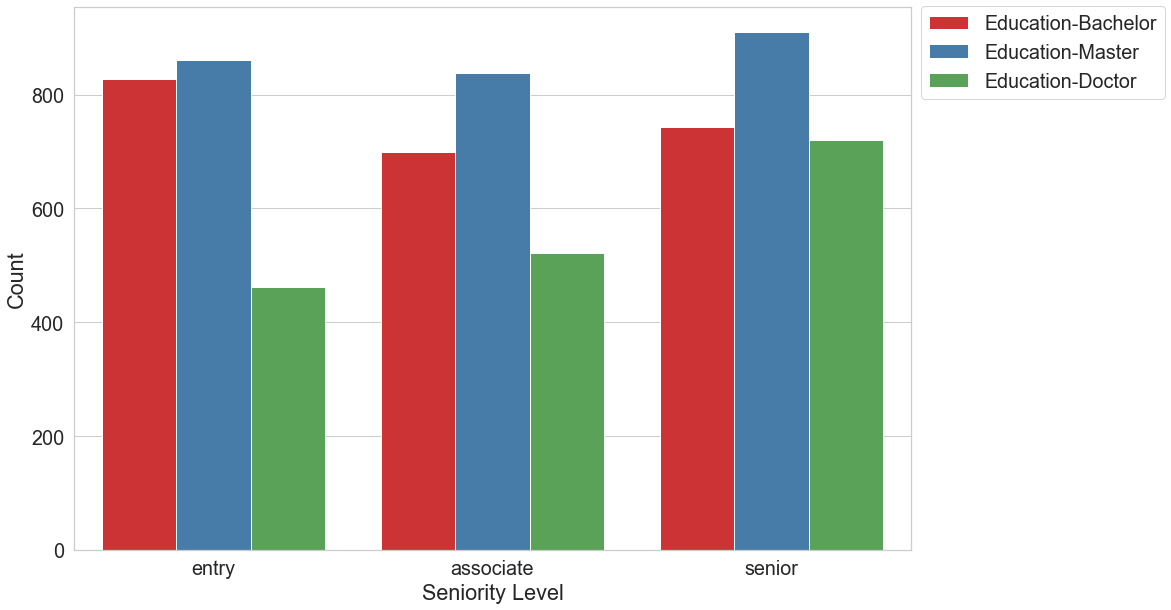

In [78]:
# plot
plt.figure(figsize = (15, 10))

sns.barplot(x = 'Seniority Level', y = 'Count', data = df_edu_count, hue = 'Degree', palette = 'Set1')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.915), ncol=1)
plt.show()

Observations:
- For all seniority levels, a Master's degree is the most commonly required.
- Bachelor's degree is second most. It is very close to Master's requirements for entry level positions and is (surprisingly) higher than PhD requirements for associate and senior level positions
- Doctoral degree is the least common requirement. It increases slightly from Entry to Senior levels

These observations run contrary to the naive, but wide-spread belief that "all data scientists have PhD degrees".

- **'Seniority Level'**

We will examine 'Seniority Level' in terms of overall representation and their standing in the low- and high-demand positions categories.

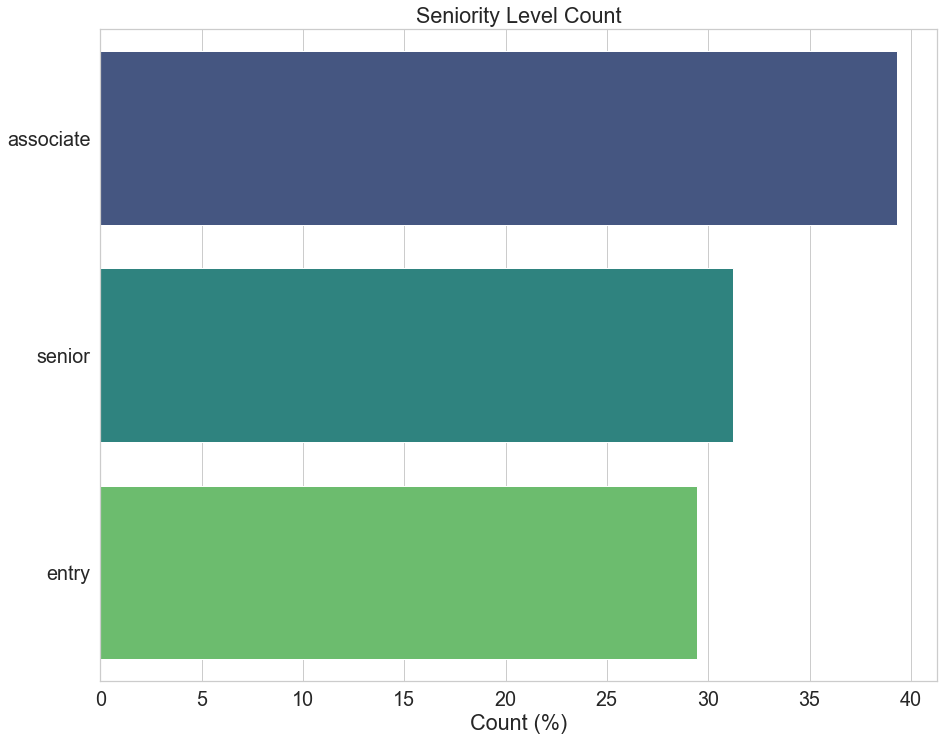

In [79]:
# get and plot 'Seniority Level' count as percentage
count_seniority = data['Seniority Level'].value_counts(normalize = True) * 100

plt.figure(figsize = (15, 12))
sns.barplot(x = count_seniority.values, y = count_seniority.index, palette = 'viridis')
plt.xlabel('Count (%)')
plt.title('Seniority Level Count')

plt.show()

The counts for all seniority levels are close with 'Associate' representing close to 40% of the data, and 'Senior' and 'Entry' levels at about 30% each.

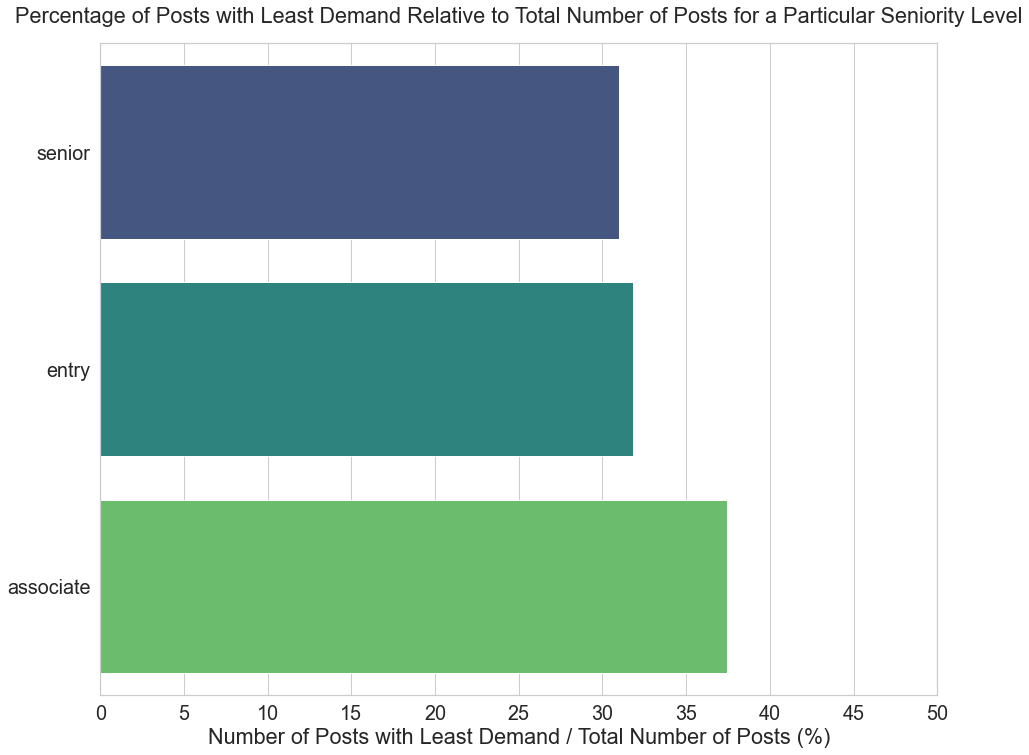

In [80]:
data_feat = 'Seniority Level'
fig_size_x = 15
fig_size_y = 12
x_max = 50
d_x = 5
plt_pts = 3

plot_demand_least(data_2, data_feat, fig_size_x, fig_size_y, x_min, x_max, d_x, plt_pts)

Similarly to the overall count, here too all seniority levels have about the same portion (20-25%) of postings in the low-demand category (five or less applicants per day). Ir is worth noting that 'Associate' positions have the most number of postings in this category at approximately 26%.

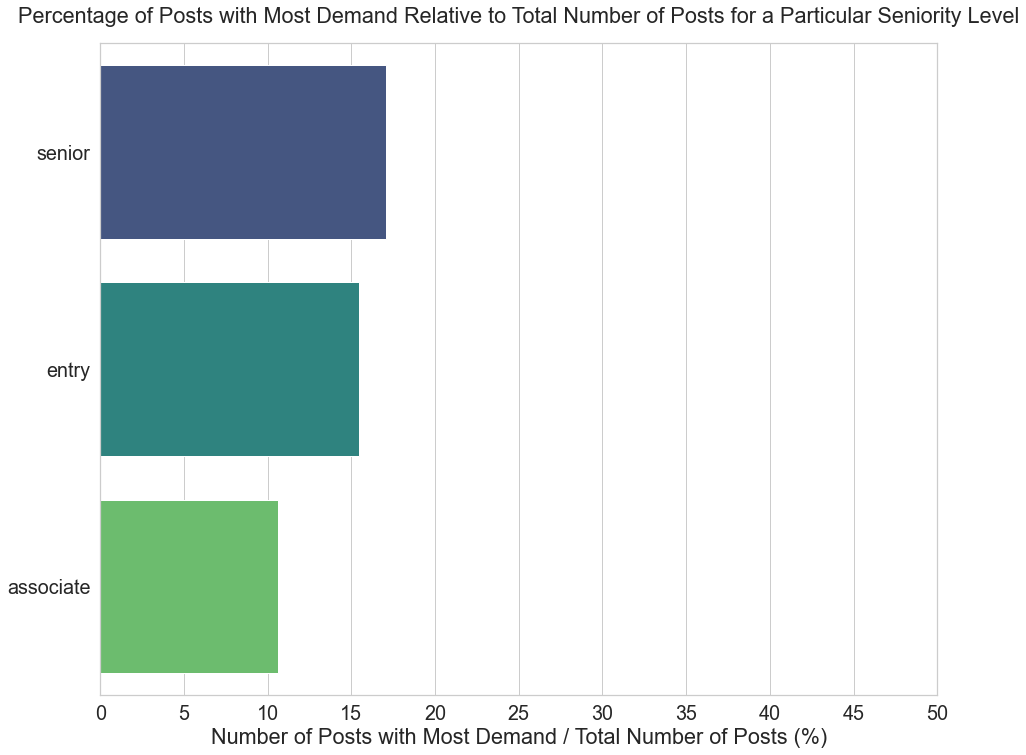

In [81]:
x_max = 50
d_x = 5
plot_demand_most(data_2, data_feat, fig_size_x, fig_size_y, x_min, x_max, d_x, plt_pts)

As the plot indicates, there are fewer postings in the high-demand category for all seniority levels. Still, the 'Associate' level has the lowest number at about 11% compared to approximately 15 and 17% for 'Entry' and 'Senior' levels respectively.

- **'Metro Area'**

Finally, we will examine 'Metro Area' in the same way as we did 'Seniority Level'.

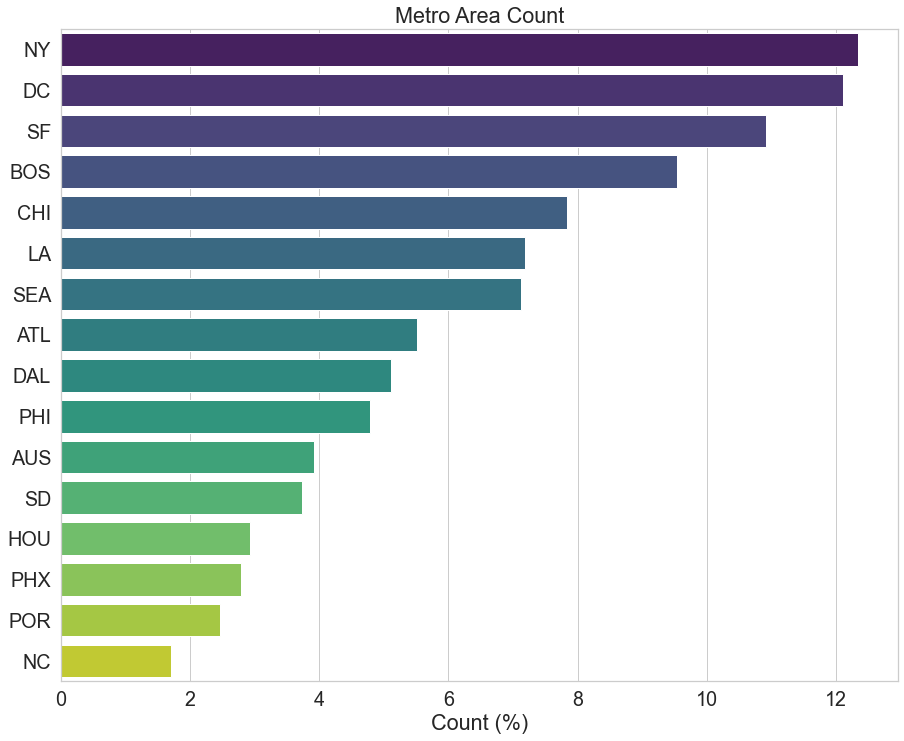

In [82]:
# get 'Metro Area' count as percentage and plot
count_metro = data['Metro Area'].value_counts(normalize = True) * 100

plt.figure(figsize = (15, 12))
sns.barplot(x = count_metro.values, y = count_metro.index, palette = 'viridis')
plt.xlabel('Count (%)')
plt.title('Metro Area Count')

plt.show()

Surprisingly to us, the top two metro areas are New York and Washington, D.C., while the expected favorite San Francisco is third, followed closely by Boston.

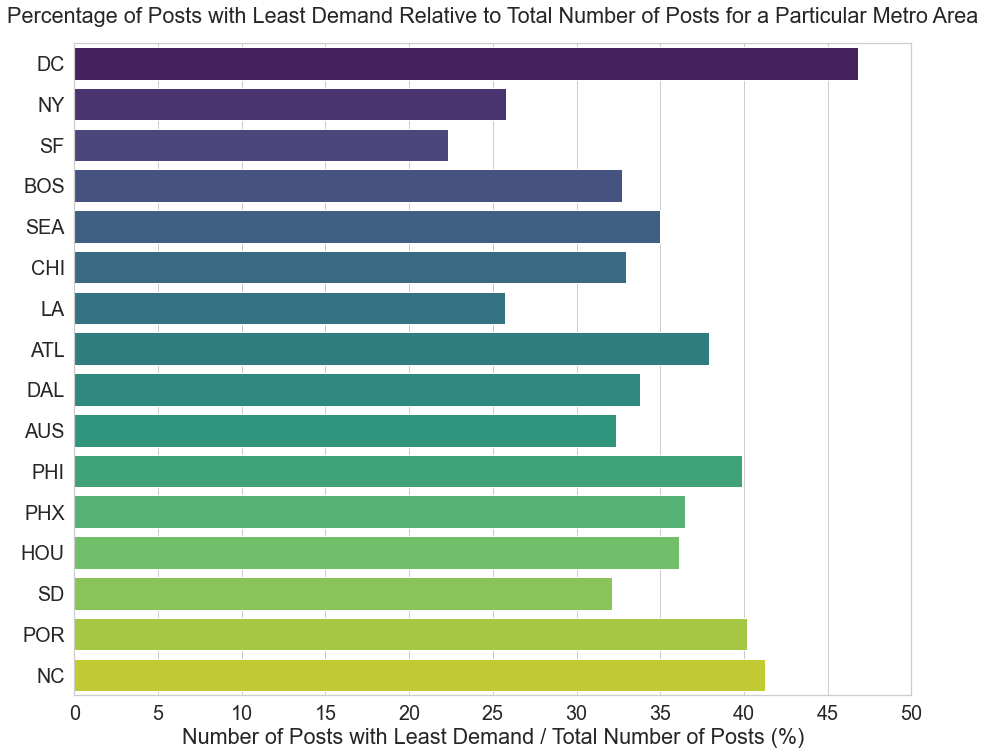

In [83]:
data_feat = 'Metro Area'
fig_size_x = 15
fig_size_y = 12
x_max = 50
d_x = 5
plt_pts = 16

plot_demand_least(data_2, data_feat, fig_size_x, fig_size_y, x_min, x_max, d_x, plt_pts)

Main observations:
- There is not extremely large difference in the number of postings for different metro areas in the low-demand category
- Metro areas with largest number of postings with five or less applicants per day are: Washington, D.C., Portland, OR, and Raleigh-Durham, NC. We would like to note that Portland, OR, and Raleigh-Durham, NC also have the smallest number of job posts relevant to our search. 
- Metro areas with the smallest number of postings in the low-demand category are: San Francisco, Los Angeles and New York

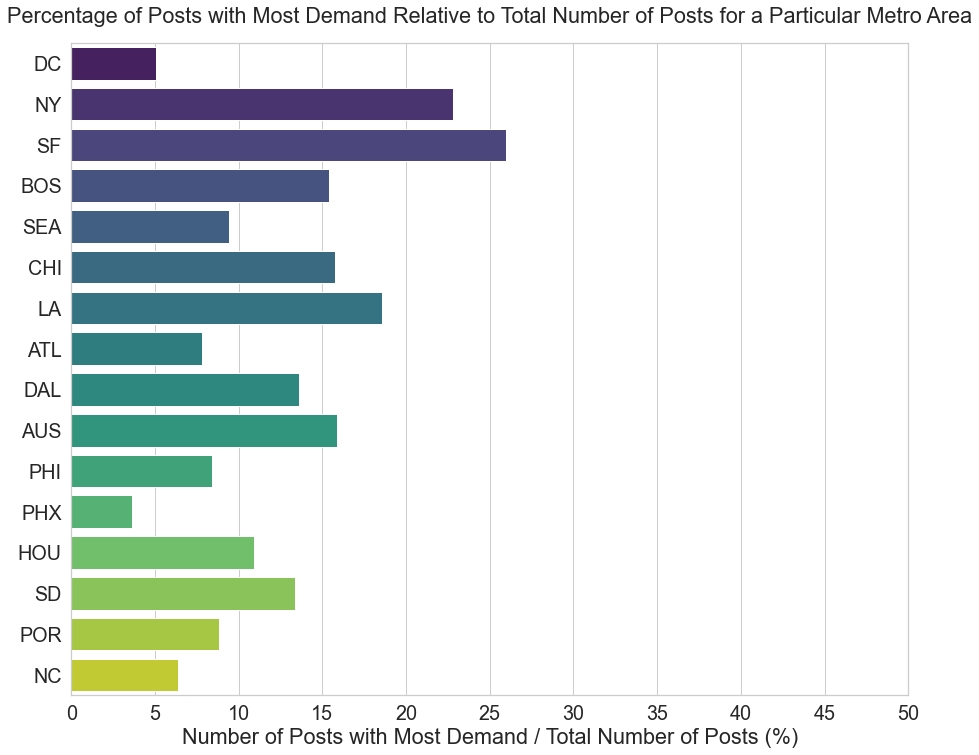

In [84]:
x_max = 50
d_x = 5
plot_demand_most(data_2, data_feat, fig_size_x, fig_size_y, x_min, x_max, d_x, plt_pts)

Main observations:
- Two of the top three markets, New York and San Francisco, have the largest number of postings at approximately 22 and 26% with more than 25 applicants per day. These are followed by Los Angeles, Austin, TX, and Boston.
- The second biggest market, Washington, D.C., on the other hand has the second smallest number of postings in this category.

Based on these observations, regarding both the overall number of job postings and the number of postings in the low- and high-demand category, Washington, D.C., appears a very attractive option which should be paid attention to in the model prediction results.

### Review data and save relevant features in a file for modeling

In [85]:
data_2.head()

,Job Title,Company Name,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Minimum Experience,Seniority Level,Data Science Terms Count,Time Posted,Number of Applicants,Applicants per Day,Position Demand,Relevance Class
0,Data Scientist,Honeywell,Staffing and Recruiting,Engineering,ATL,0,1,1,2,entry,7,2,40,20,3,3
1,Data Scientist,SynergisticIT,Staffing and Recruiting,Information Technology,ATL,1,1,0,10,entry,2,1,0,25,3,1
2,Data Scientist,Inspire Brands,Financial Services,Engineering,ATL,0,0,0,1,entry,4,1,25,25,3,2
3,Data Scientist,The Home Depot,Financial Services,Engineering,ATL,0,1,0,2,entry,3,1,29,29,4,2
4,Data Scientist,Edelman Data & Intelligence (DxI),Research,Analyst,ATL,0,0,0,3,entry,3,1,0,25,3,2


In [86]:
data_2.columns

Index(['Job Title', 'Company Name', 'Industry', 'Job Function', 'Metro Area',
       'Education-Bachelor', 'Education-Master', 'Education-Doctor',
       'Minimum Experience', 'Seniority Level', 'Data Science Terms Count',
       'Time Posted', 'Number of Applicants', 'Applicants per Day',
       'Position Demand', 'Relevance Class'],
      dtype='object')

In [87]:
# select all relevant features we will continue to work with and create a new data set, data_1
save_features = ['Job Title', 'Industry', 'Job Function', 'Metro Area', 
                 'Education-Bachelor', 'Education-Master', 'Education-Doctor', 
                 'Seniority Level', 'Relevance Class', 'Position Demand']

save_data = data_2[save_features]
save_data.head()

,Job Title,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Seniority Level,Relevance Class,Position Demand
0,Data Scientist,Staffing and Recruiting,Engineering,ATL,0,1,1,entry,3,3
1,Data Scientist,Staffing and Recruiting,Information Technology,ATL,1,1,0,entry,1,3
2,Data Scientist,Financial Services,Engineering,ATL,0,0,0,entry,2,3
3,Data Scientist,Financial Services,Engineering,ATL,0,1,0,entry,2,4
4,Data Scientist,Research,Analyst,ATL,0,0,0,entry,2,3


In [88]:
# save data as an excel file

file_save = file_read + 'model.xlsx'

save_data.to_excel(file_save, index = False)